## Data Processing

This code:
- import multi-variable .nc files, with depth interpolated mrsol for a given region
- calculate land fraction (and make land fraction estimates for models without available land fraction data) 
- calculate SPI
- calculate zscore (standardized monthly anomaly)
- export out standardized anomaly for each region, model, ensemble member and variable 

### Necessary Packages & Functions

In [1]:
# data import
import zarr
import fsspec
import intake
from dask.diagnostics import ProgressBar

# data analysis
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import dask 
import rioxarray
from scipy import stats as st

import cftime
import nc_time_axis

import intake

import warnings
warnings.filterwarnings("ignore")

# progress bars for loops
from tqdm.notebook import tqdm  

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

import string

from IPython import display
display.set_matplotlib_formats('retina')

In [2]:
def process(ds):
    ### constrain time series from 1850 to 2100 
    if type(ds.time.data[0]) is cftime._cftime.DatetimeNoLeap:
        end_of_century = cftime.DatetimeNoLeap(2101, 1, 1, has_year_zero=True)
    
    if type(ds.time.data[0]) is cftime._cftime.DatetimeProlepticGregorian:
        end_of_century = cftime.datetime(2101, 1, 1, 0, 0, 0, 0, calendar='proleptic_gregorian', has_year_zero=False)

    if type(ds.time.data[0]) is cftime._cftime.Datetime360Day:
        end_of_century = cftime.Datetime360Day(2101, 1, 1, 0, 0, 0, 0, has_year_zero=True)
    
    if type(ds.time.data[0]) is cftime._cftime.DatetimeGregorian:
        end_of_century = cftime.DatetimeGregorian(2101, 1, 1, 0, 0, 0, 0, has_year_zero=False)
        
    ds = ds.where(ds.time <= end_of_century, drop = True)
    
    return ds

def fix_lon(ds):
    '''
    adjust longitude to be [-180, 180]
    '''
    ds = ds.copy()
    
    ## TO DO FIGURE OUT HOW TO KEEP LONGITUDE ATTRIBUTES 
    if ds.lon.max() > 180:
        
        ds.coords['lon'] = ((ds.coords['lon'] + 180) % 360 - 180) 
        ds = ds.sortby(ds.lon)

    return ds

def fix_lat(ds):
    '''
    some models have some wild floating point situtations going on in the latitude values
    this is relevant: https://xkcd.com/2170/ 
    
    so i'm rounding to the 3rd decimal point.
    
    this has the added bonus of being able to merge Lmon/Emon variables with Amon ones
    '''
    
    ds.coords['lat'] = (np.round(ds.coords['lat'], 3))
    
    return ds

def process_coords(ds):
    
    ds = fix_lon(ds)
    ds = fix_lat(ds)
    
    return ds

### GLOBAL MEANS ###

def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    """
    Calculate weighted global mean average
    """
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'} - {'year'} - {'member_id'} - {'depth'}
    return (ds * weight).mean(other_dims)



### Import Model Data

In [3]:
models = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CanESM5', 
          'CESM2', 'CESM2-WACCM', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'GISS-E2-1-G',
          'IPSL-CM6A-LR', 'KACE-1-0-G', 'MIROC6', 'MPI-ESM1-2-LR',
          'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-LM', 'NorESM2-MM',
          'TaiESM1', 'UKESM1-0-LL']

#models = ['TaiESM1']

variables_for_import = ['mrsol', 'mrsos', 'pr']
variables = ['mrsos', 'mrsol', 'pr']

experiments = ['historical', 'ssp585']

In [4]:
models.sort()

regions = [['MED'], ['WNA']]

dict_of_MED = dict()
dict_of_WNA = dict()
dicts = [dict_of_MED, dict_of_WNA]

#project_prefix = os.getcwd()
project_prefix = '~/precip-events'

print_string = "-"

for region, i in zip(regions, dicts):
    fn_prefix = '/exported_data/regions/' + print_string.join(region) + '/' 

    for model in tqdm(models): 
        fname = (project_prefix + fn_prefix + model + '_depth_interpolated_' 
                 + print_string.join(variables_for_import) + '.nc')

        i[model] = process(xr.open_dataset(fname, use_cftime = True).load())


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [5]:
dict_of_MED['UKESM1-0-LL']

<xarray.Dataset>
Dimensions:    (member_id: 5, time: 3012, lat: 12, lon: 26, depth: 3)
Coordinates:
  * time       (time) object 1850-01-16 00:00:00 ... 2100-12-16 00:00:00
  * lon        (lon) float32 -8.438 -6.562 -4.688 -2.812 ... 34.69 36.56 38.44
  * lat        (lat) float32 30.62 31.88 33.12 34.38 ... 40.62 41.88 43.12 44.38
  * member_id  (member_id) object 'r1i1p1f2' 'r2i1p1f2' ... 'r8i1p1f2'
  * depth      (depth) object '30cm' '100cm' '200cm'
Data variables:
    mrsos      (member_id, time, lat, lon) float32 2.739 1.918 ... nan 24.27
    pr         (member_id, time, lat, lon) float32 3.323e-07 ... 5.949e-06
    mrsol      (depth, member_id, time, lat, lon) float32 33.68 32.31 ... 418.9
Attributes:
    Conventions:  IRIDL

In [5]:
dict_of_MED['TaiESM1']

<xarray.Dataset>
Dimensions:    (member_id: 1, time: 3012, lat: 16, lon: 40, depth: 3)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lat        (lat) float64 30.63 31.57 32.51 33.45 ... 41.94 42.88 43.82 44.76
  * lon        (lon) float64 -8.75 -7.5 -6.25 -5.0 ... 36.25 37.5 38.75 40.0
  * member_id  (member_id) object 'r1i1p1f1'
  * depth      (depth) object '30cm' '100cm' '200cm'
Data variables:
    mrsos      (member_id, time, lat, lon) float32 11.47 14.3 ... 34.58 42.05
    pr         (member_id, time, lat, lon) float32 2.566e-07 ... 3.465e-05
    mrsol      (depth, member_id, time, lat, lon) float32 41.24 51.23 ... 684.8
Attributes: (12/50)
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 0671-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     171550.0
    ...                        ...
    title:                     TaiESM1 output prepared for CMIP6
    variable_id:               mrsol
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.5.0
    tracking_id:               hdl:21.14100/98a43e52-7cbb-40c3-85b8-5c2195f4f60d

#### Download sftlf files available on Pangeo

In [6]:
# cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
# col = intake.open_esm_datastore(cat_url)

# cat = col.search(experiment_id=['historical'],  variable_id='sftlf', source_id = models)
# #cat.df

# dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True})
# list(dset_dict.keys())

# for key in tqdm(dset_dict.keys()):
#     output_fn = 'exported_data/surface-to-land-fraction/' + key.split('.')[2] + '_sftlf_pangeo.nc'
#     dset_dict[key].to_netcdf(output_fn)

#### Import sftlf files

In [7]:
dict_sftlf = dict()
missing_sftlf_mod = []

for model in models:
    try:
        import_fn = 'exported_data/surface-to-land-fraction/' + model + '_sftlf_pangeo.nc'
        dict_sftlf[model] = process_coords(xr.open_dataset(import_fn)).load()
    except:
        missing_sftlf_mod.append(model)
        print('missing sftlf for ' + model)

#### Create missing sftlf files
Not all CMIP6 models have published `sfltf` (surface to land fraction) files on Pangeo or (going directly to the source) ESGF . This code creates some from a 1-km DEM, regridded to the precipitation grid of the model.

Using the 30m land grid from [here](https://zenodo.org/record/1447210#.YRWJMS335hE) (30m is way more than needed, but it's somehow frustratingly difficult to just find a damn 1km global land or DEM grid).

The bulk of this code is from Kevin Schwarzwald.

In [8]:
# sftlf_ref = rioxarray.open_rasterio('aux_data/dtm_curvature_merit.dem_m_1km_s0..0cm_2017_v1.0.tif').isel(band=0)

# sftlf_ref = sftlf_ref.load()
# sftlf_ref = sftlf_ref.rename({'y':'lat','x':'lon'})

# # coarsening the sftlf reference file to avoid memory issues; 
# # more isn't really needed anyways
# # could coarsen futher to ~0.25 degrees -- lon = 40, lat = 40 
# # if i wanted
# sftlf_ref = sftlf_ref.coarsen({'lat':10,
#                                'lon':10}, boundary = 'trim').mean().drop('band')

# # Do this in numpy instead of xarray; which is terrible at indexing
# # Replacing all ocean pixels (nans in the DEM) with 0, all land pixels
# # with 100
# sftlf_tmp = sftlf_ref.values.flatten()
# sftlf_tmp[sftlf_tmp>-30000] = 1
# sftlf_tmp[sftlf_tmp<-30000] = 0

# # Recreate the original dataarray
# sftlf_ref = xr.DataArray(sftlf_tmp.reshape(sftlf_ref.shape),coords=[sftlf_ref.lat,sftlf_ref.lon],dims=['lat','lon'])

In [9]:
# dict_1850 = dict()

# base_fn = '../../kdm2144/DROUGHT/DOWNLOADED_RAW/pr/'

# for model in tqdm(missing_sftlf_mod):
#     try: 
#         dict_1850[model] = xr.open_dataset(base_fn + model + '/pr.historical.' + model + '.r1i1p1f1.1850.nc')
#     except: 
#         dict_1850[model] = xr.open_dataset(base_fn + model + '/pr.historical.' + model + '.r10i1p1f2.1850.nc')

In [10]:
# for model in tqdm(missing_sftlf_mod):
#     output_fn = 'exported_data/surface-to-land-fraction/' + model + '_sftlf_DTMrgrd.nc'
    
#     ds = dict_1850[model]
#     rgrd = xe.Regridder(sftlf_ref, ds.drop(['lat_bnds', 'lon_bnds']), 'bilinear')
#     sftlf_tmp = rgrd(sftlf_ref)
#     #rgrd.clean_weight_file()
#     sftlf_tmp = sftlf_tmp.to_dataset(name='sftlf')
#     sftlf_tmp.attrs['SOURCE'] = 'create_sftlf_files.ipnyb'
#     sftlf_tmp.attrs['DESCRIPTION'] = "surface to land fraction files created by regridding a dem to the target model (precipitation file)'s grid; created because this model had no sftlf file up on ESGF."
    
    
#     sftlf_tmp.to_netcdf(output_fn)
#     print(output_fn+' saved!')    

#### Import created sftlf

In [11]:
for model in tqdm(missing_sftlf_mod):
    import_fn = 'exported_data/surface-to-land-fraction/' + model + '_sftlf_DTMrgrd.nc'
    dict_sftlf[model] = process_coords(xr.open_dataset(import_fn).load())

0it [00:00, ?it/s]

### Calculate Land Fraction

Solved issues: 
- TaiESM1 seems to also be crashing the kernel -- couldn't handle the if/then logic for percentile selection so I changed that to happen outside of the masking function
- multiple models (['CNRM-CM6-1','CNRM-ESM2-1', 'CanESM5', 'NorESM2-LM', 'MPI-ESM1-2-HR', 'MRI-ESM2-0']) had issues with latitude matching the downloaded sftlf. I created a very hacky solution that selects the nearest latitude from the main dataset in the sftlf datasetand then uses those new values to re-assign coordinates to the main dataset. This is not ideal, but the numbers all seem to match visually. I suspect this is some kind of weird floating point and/or datatype issue, but I do not think it is impacting the output.  
- NorESM2-MM where function is not working but not for the usual lat/lon reasons, turns out the available sftlf did not have a matching member_id, solution: just use the first member for all the sftlf, since they should be the same 


In [12]:
def apply_sftlf_mask(ds, ds_with_sftlf, percentile, area_type = 'land'):
    """Mask ocean or land using a sftlf (land surface fraction) file.
    If land fraction is greater than a given percentile for a given pixel, include.
    """
    
    if area_type == 'land':
        masked_ds = ds.where(ds_with_sftlf.sftlf >= percentile)
    else:
        masked_ds = ds.where(ds_with_sftlf.sftlf <= percentile)   
                        
    return masked_ds

In [13]:
dicts_land_fraction = dict({'MED': dict(), 'WNA': dict()})

for region, i in zip(dicts_land_fraction, dicts):
    for model in tqdm(models):
        #print(model)
        ds = i[model]
        sftlf = dict_sftlf[model]

        if model in missing_sftlf_mod:
            percentile = 0.5
            
        else:
            percentile = 50
        
        if model in ['CNRM-CM6-1','CNRM-ESM2-1', 'CanESM5', 'NorESM2-LM', 'MPI-ESM1-2-HR', 'MRI-ESM2-0', 'TaiESM1']: 
            ## print(model + ' hacky solution activated')
            ## not sure what exactly is causing this problem
            ## the lats in both data sets match, but this hackish solution does work
            ## NorESM2-LM did not need method = 'nearest' but MPI-ESM1-2-HR did
            ## doesn't seem to change results, used for all the other problem models
            sftlf = sftlf.sel(lat = ds.lat, method = 'nearest')
            ds = ds.assign_coords({"lat": sftlf.lat})
        
        if model in ['NorESM2-MM']:
            ## grabbing only the first member_id, as the land fraction 
            ## should be the same across all of them
            sftlf = sftlf.isel(member_id = 0)

        dicts_land_fraction[region][model] = apply_sftlf_mask(ds, sftlf, percentile)
    

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

### Check Land Fraction

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

TaiESM1


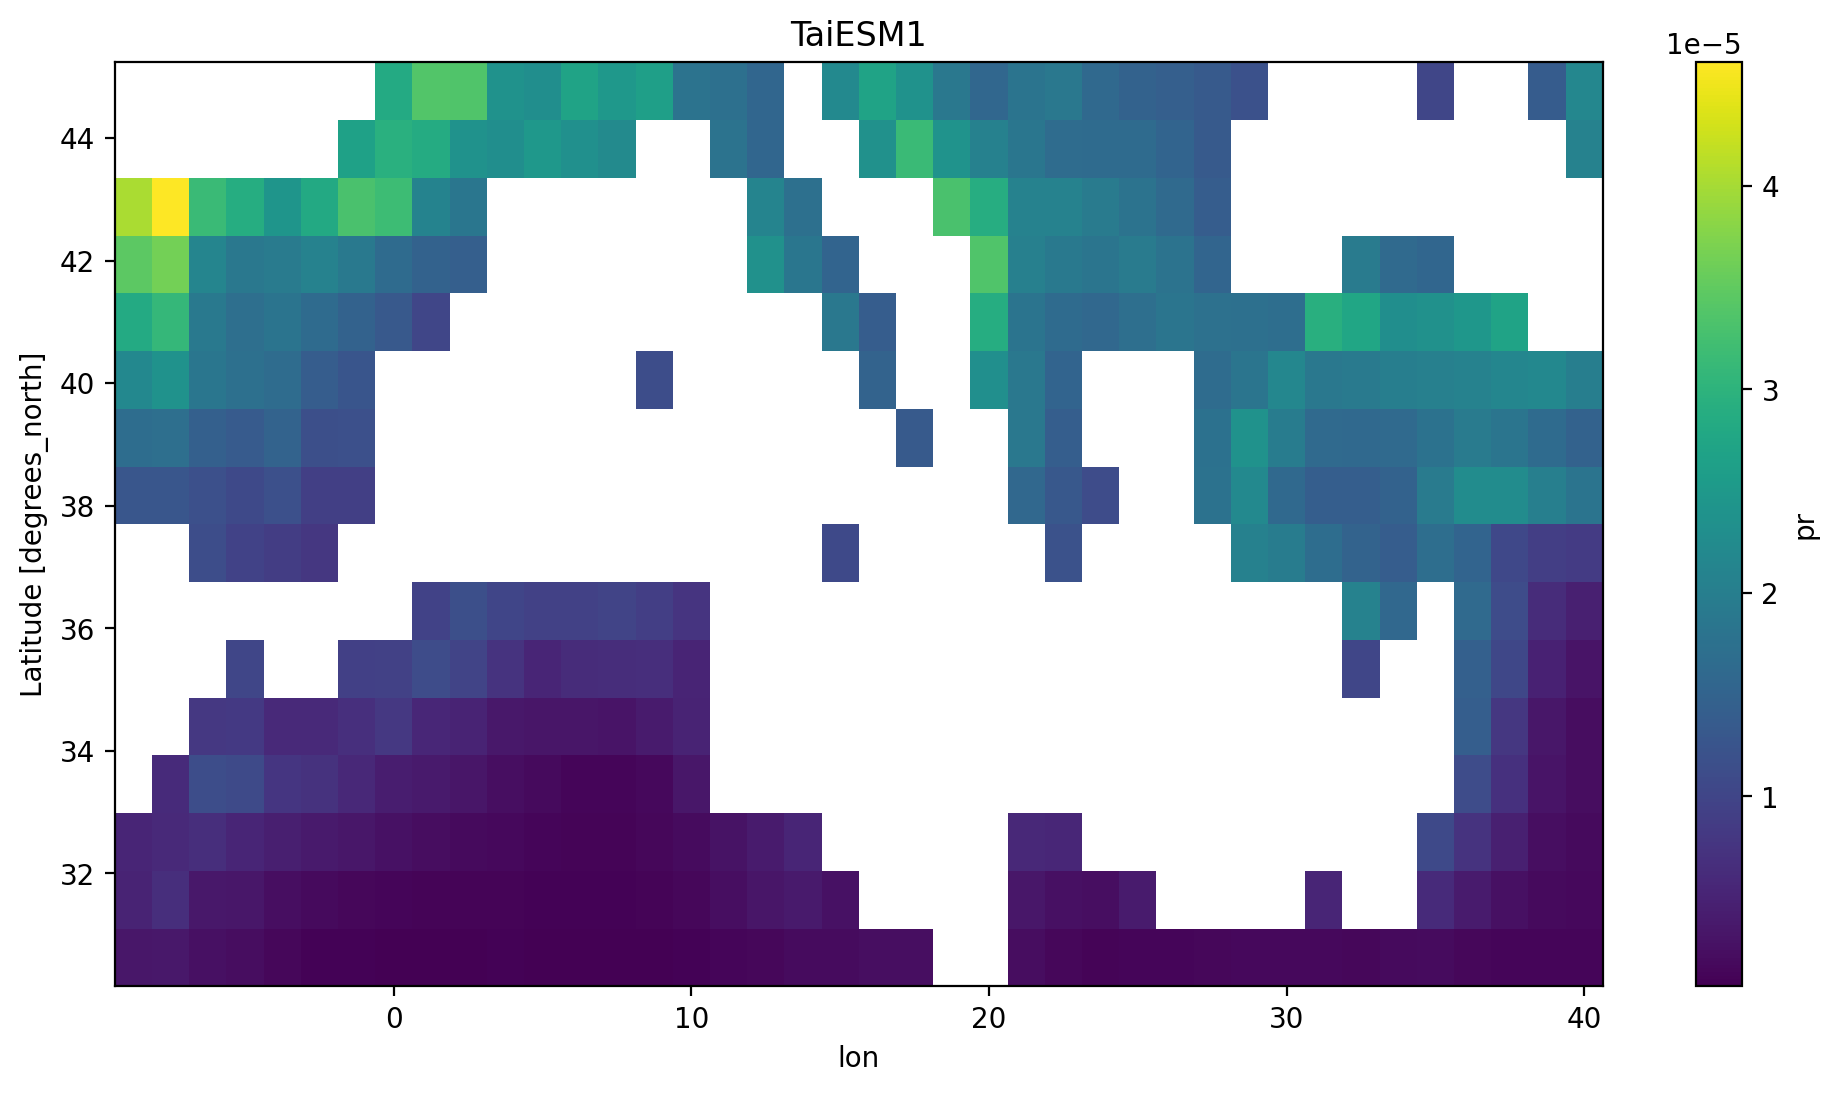

  0%|          | 0/1 [00:00<?, ?it/s]

TaiESM1


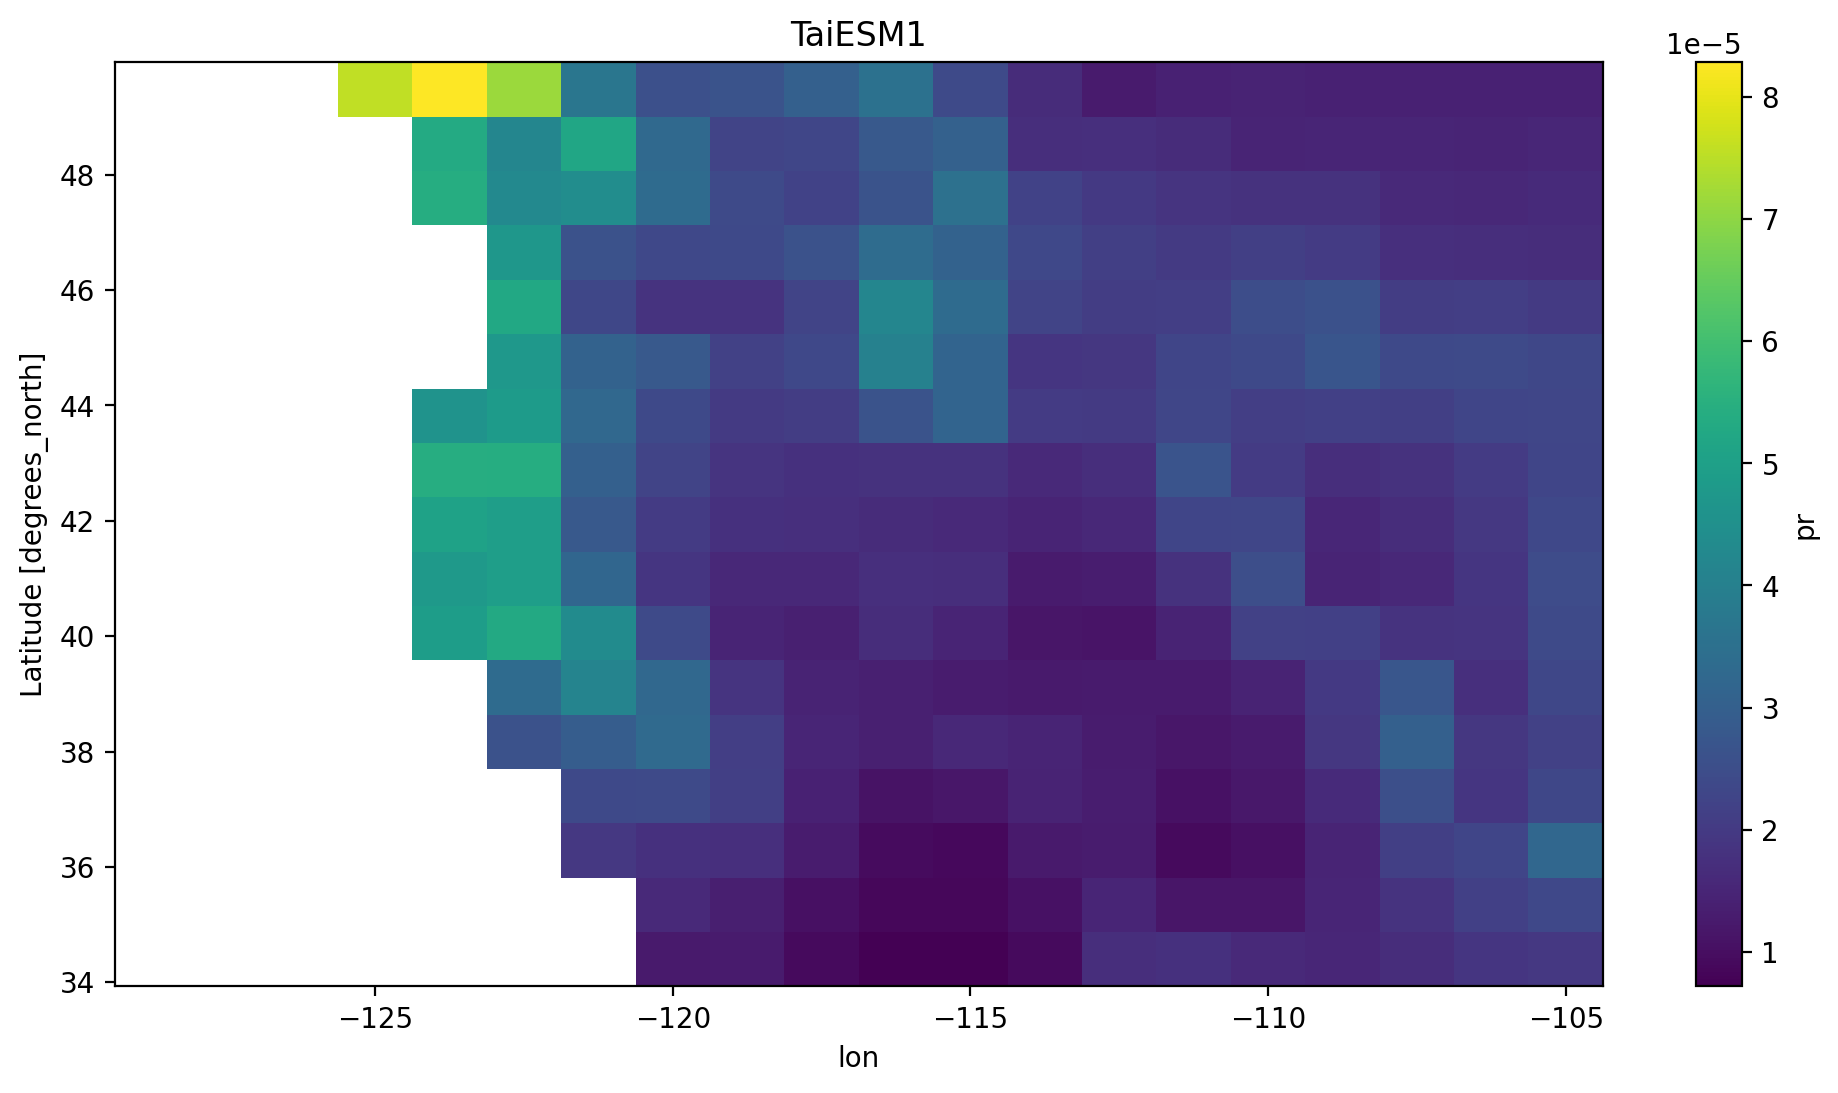

In [14]:
for region in tqdm(dicts_land_fraction):
    for model in tqdm(models):
        print(model)
        ds = dicts_land_fraction[region][model]
        
        ds.mean(dim = ['time', 'member_id']).pr.plot()
        plt.title(model)
        plt.show()

### Fixing some errors:

- Not all members for all models go from 1850 to 2100
- i should go back and re-download/double check that everything is correct from the beginning

Currently (3.13.23) models without SSP members:
- ACCESS-CM2: 'r2i1p1f1'
- MRI-ESM2-0: 'r2i1p1f1', 'r3i1p1f1', 'r4i1p1f1', 'r5i1p1f1'

Removing these members:

In [15]:
# for region in regions: 
#     access_members_short = ['r2i1p1f1']
#     mri_members_short = ['r2i1p1f1', 'r3i1p1f1', 'r4i1p1f1', 'r5i1p1f1']
    
#     region = region[0]
    
#     dicts_land_fraction[region]['ACCESS-CM2'] = dicts_land_fraction[region]['ACCESS-CM2'].where(~dicts_land_fraction[region]['ACCESS-CM2'].member_id.isin(access_members_short),
#                                                                                                 drop = True)
#     dicts_land_fraction[region]['MRI-ESM2-0'] = dicts_land_fraction[region]['MRI-ESM2-0'].where(~dicts_land_fraction[region]['MRI-ESM2-0'].member_id.isin(mri_members_short), 
#                                                                                                 drop = True)

### Calculate SPI

In [16]:
def spi(ds, time_interval, calibration_years = ['1861', '1880']):

    ### Estimate gamma fit parameters 
    ds_rolling = ds.rolling(time = time_interval, center = False).mean(skipna = True)

    # estimate fit with calibration time period
    ds_calibration = ds_rolling.sel(time = slice(calibration_years[0], calibration_years[1]))

    zeros = (ds_calibration == 0).sum(axis=0)
    probabilities_of_zero = zeros / ds_calibration.shape[0]

    # ## trim 0 values
    ds_calibration = ds_calibration.where(ds_calibration != 0, drop = True)

    ds_mean = ds_calibration.groupby('time.month').mean(dim = 'time', skipna = True)

    ds_logs = np.log(ds_calibration.groupby('time.month'))
    ds_logs = ds_logs.where(~np.isinf(ds_logs), drop = True).groupby('time.month') ## remove infinity values
    ds_log_sums = ds_logs.sum(dim = 'time')

    A = np.log(ds_mean) - ds_logs.mean(dim = 'time', skipna = True) 
    alpha = (1/(4*A)) * (np.sqrt(1+(4*A/3))+1)
    beta = ds_mean/alpha

    #print('rolling data count : ' + str(np.count_nonzero(~np.isnan(global_mean(ds_rolling).data))))
    # ## Gamma Distribution (CDF) of calibration period
    gcdf = lambda x, a, b: st.gamma.cdf(x, a = a, scale = b)
    gamma = xr.apply_ufunc(gcdf, ds_rolling.groupby('time.month'), alpha, beta)
    #print('gamma count : ' + str(np.count_nonzero(~np.isnan(global_mean(gamma).data))))

    ## Normalize ## FROM CLIMATE INDICES PACKAGE
     # (normalize including the probability of zero, putting into the range [0..1]?)
    probabilities = probabilities_of_zero + \
                        ((1 - probabilities_of_zero) * gamma)
    # the values we'll return are the values at which the probabilities of
    # a normal distribution are less than or equal to the computed probabilities,
    # as determined by the normal distribution's quantile (or inverse
    # cumulative distribution) function

    # ## Standardized Precipitation Index (Inverse of Gamma CDF)
    spi_func = lambda x: st.norm.ppf(x, loc = 0, scale = 1)
    norm_spi = xr.apply_ufunc(spi_func, probabilities.groupby('time.month'))
    #norm_spi = xr.apply_ufunc(spi_func, gamma.groupby('time.month'))
    #print('norm_spi total count: ' + str(np.count_nonzero(~np.isnan(norm_spi).data)))
    #print('norm_spi count : ' + str(np.count_nonzero(~np.isnan(global_mean(norm_spi).data))))

    ## remove infinities
    inf_count = np.isinf(norm_spi.data).sum()
    norm_spi = norm_spi.where(~np.isinf(norm_spi))
    #print('norm_spi total count: ' + str(np.count_nonzero(~np.isnan(norm_spi).data)))
    #print('norm_spi count : ' + str(np.count_nonzero(~np.isnan(global_mean(norm_spi).data))))
    
    return norm_spi, inf_count

In [17]:
dicts_spi = dict({'MED': dict(), 'WNA': dict()})
calibration_years = ['1861', '1880']


for region in tqdm(regions): 
    print(region)
    for model in tqdm(models):
        #print(model)
        ds = dicts_land_fraction[region[0]][model]

        tmp_spi = []
        for member in ds.member_id:
            #print(member)
            da = ds.sel(member_id = member)

            SPI = da.copy()
            intervals = dict({'spi_1': 1, 'spi_3': 3, 'spi_6': 6})

            for i, var in zip(intervals.values(), intervals.keys()):
                norm_spi, inf_count = spi(da.pr, time_interval = i)
                SPI[var] = norm_spi
                SPI.attrs['spi source'] = '02_data_processing.ipnyb'
                SPI.attrs['spi description'] = 'SPI calculation using gamma distribution calibrated to model years ' + \
                                                calibration_years[0] + '-' + calibration_years[1] + \
                                                'with ' + str(inf_count) + ' infinity values removed'
                SPI = SPI.drop_vars('month')

            tmp_spi.append(SPI)

        dicts_spi[region[0]][model] = xr.concat(tmp_spi, dim = 'member_id')

  0%|          | 0/2 [00:00<?, ?it/s]

['MED']


  0%|          | 0/1 [00:00<?, ?it/s]

['WNA']


  0%|          | 0/1 [00:00<?, ?it/s]

#### Test SPI

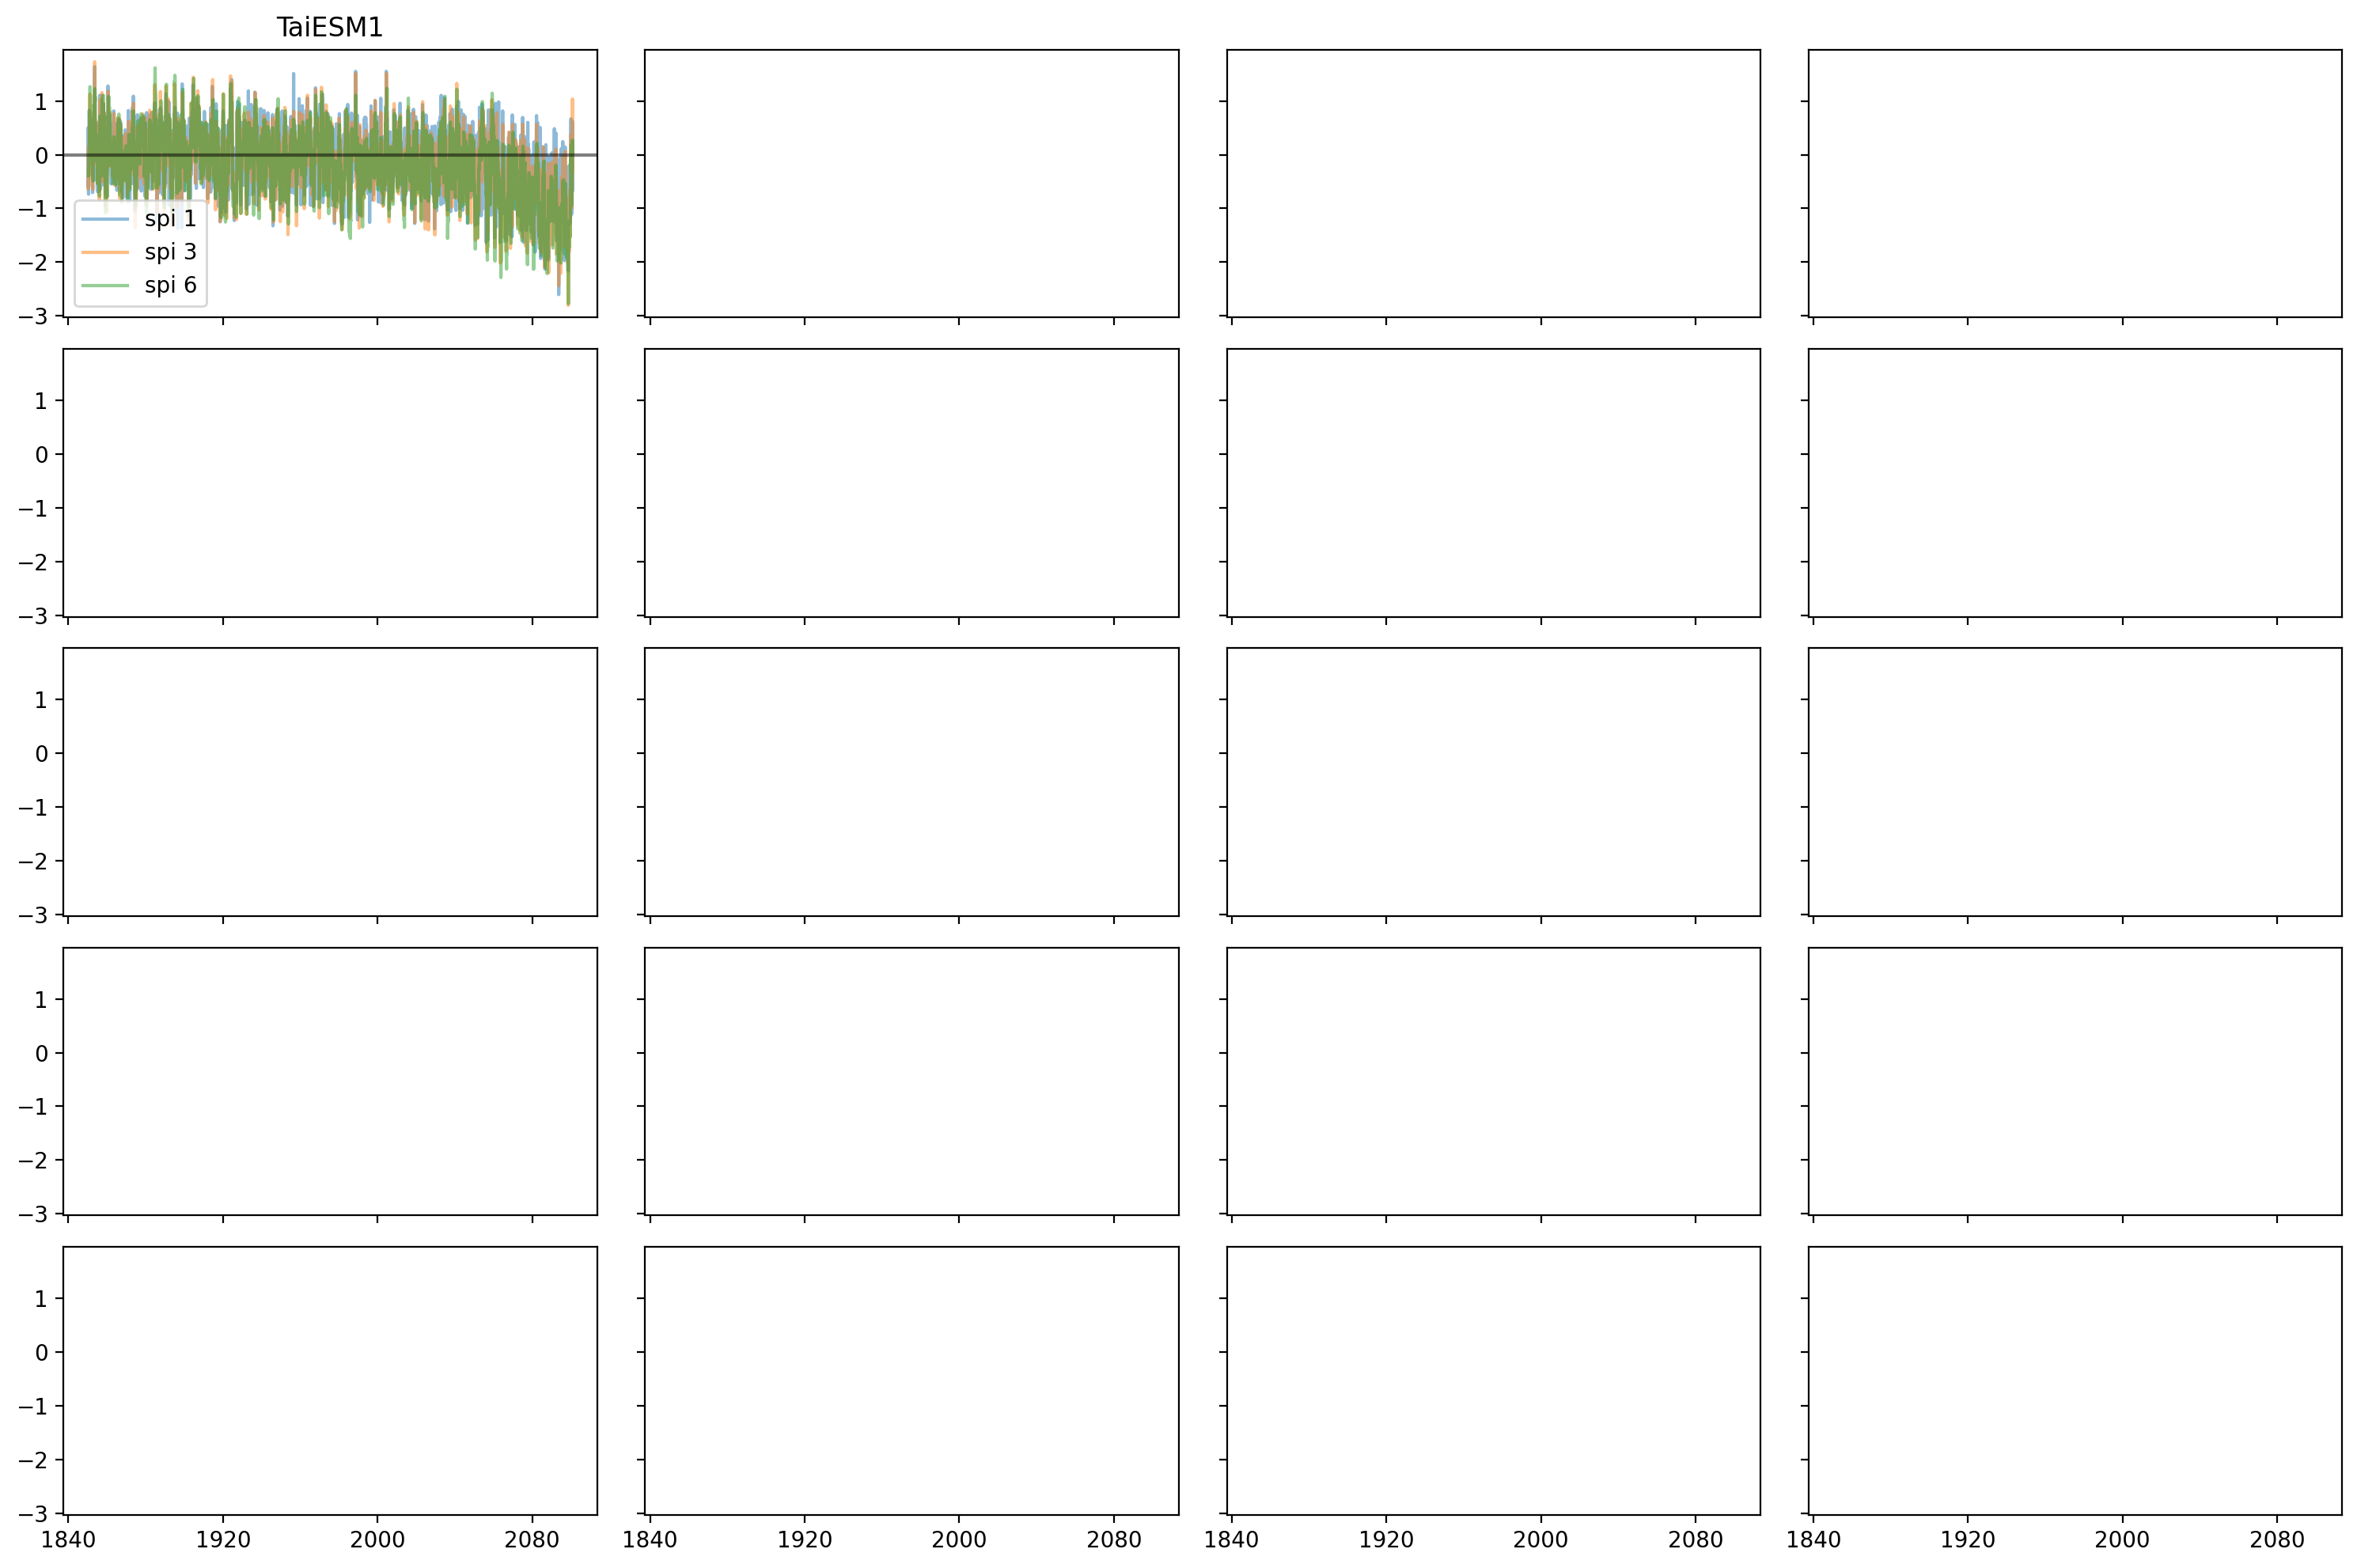

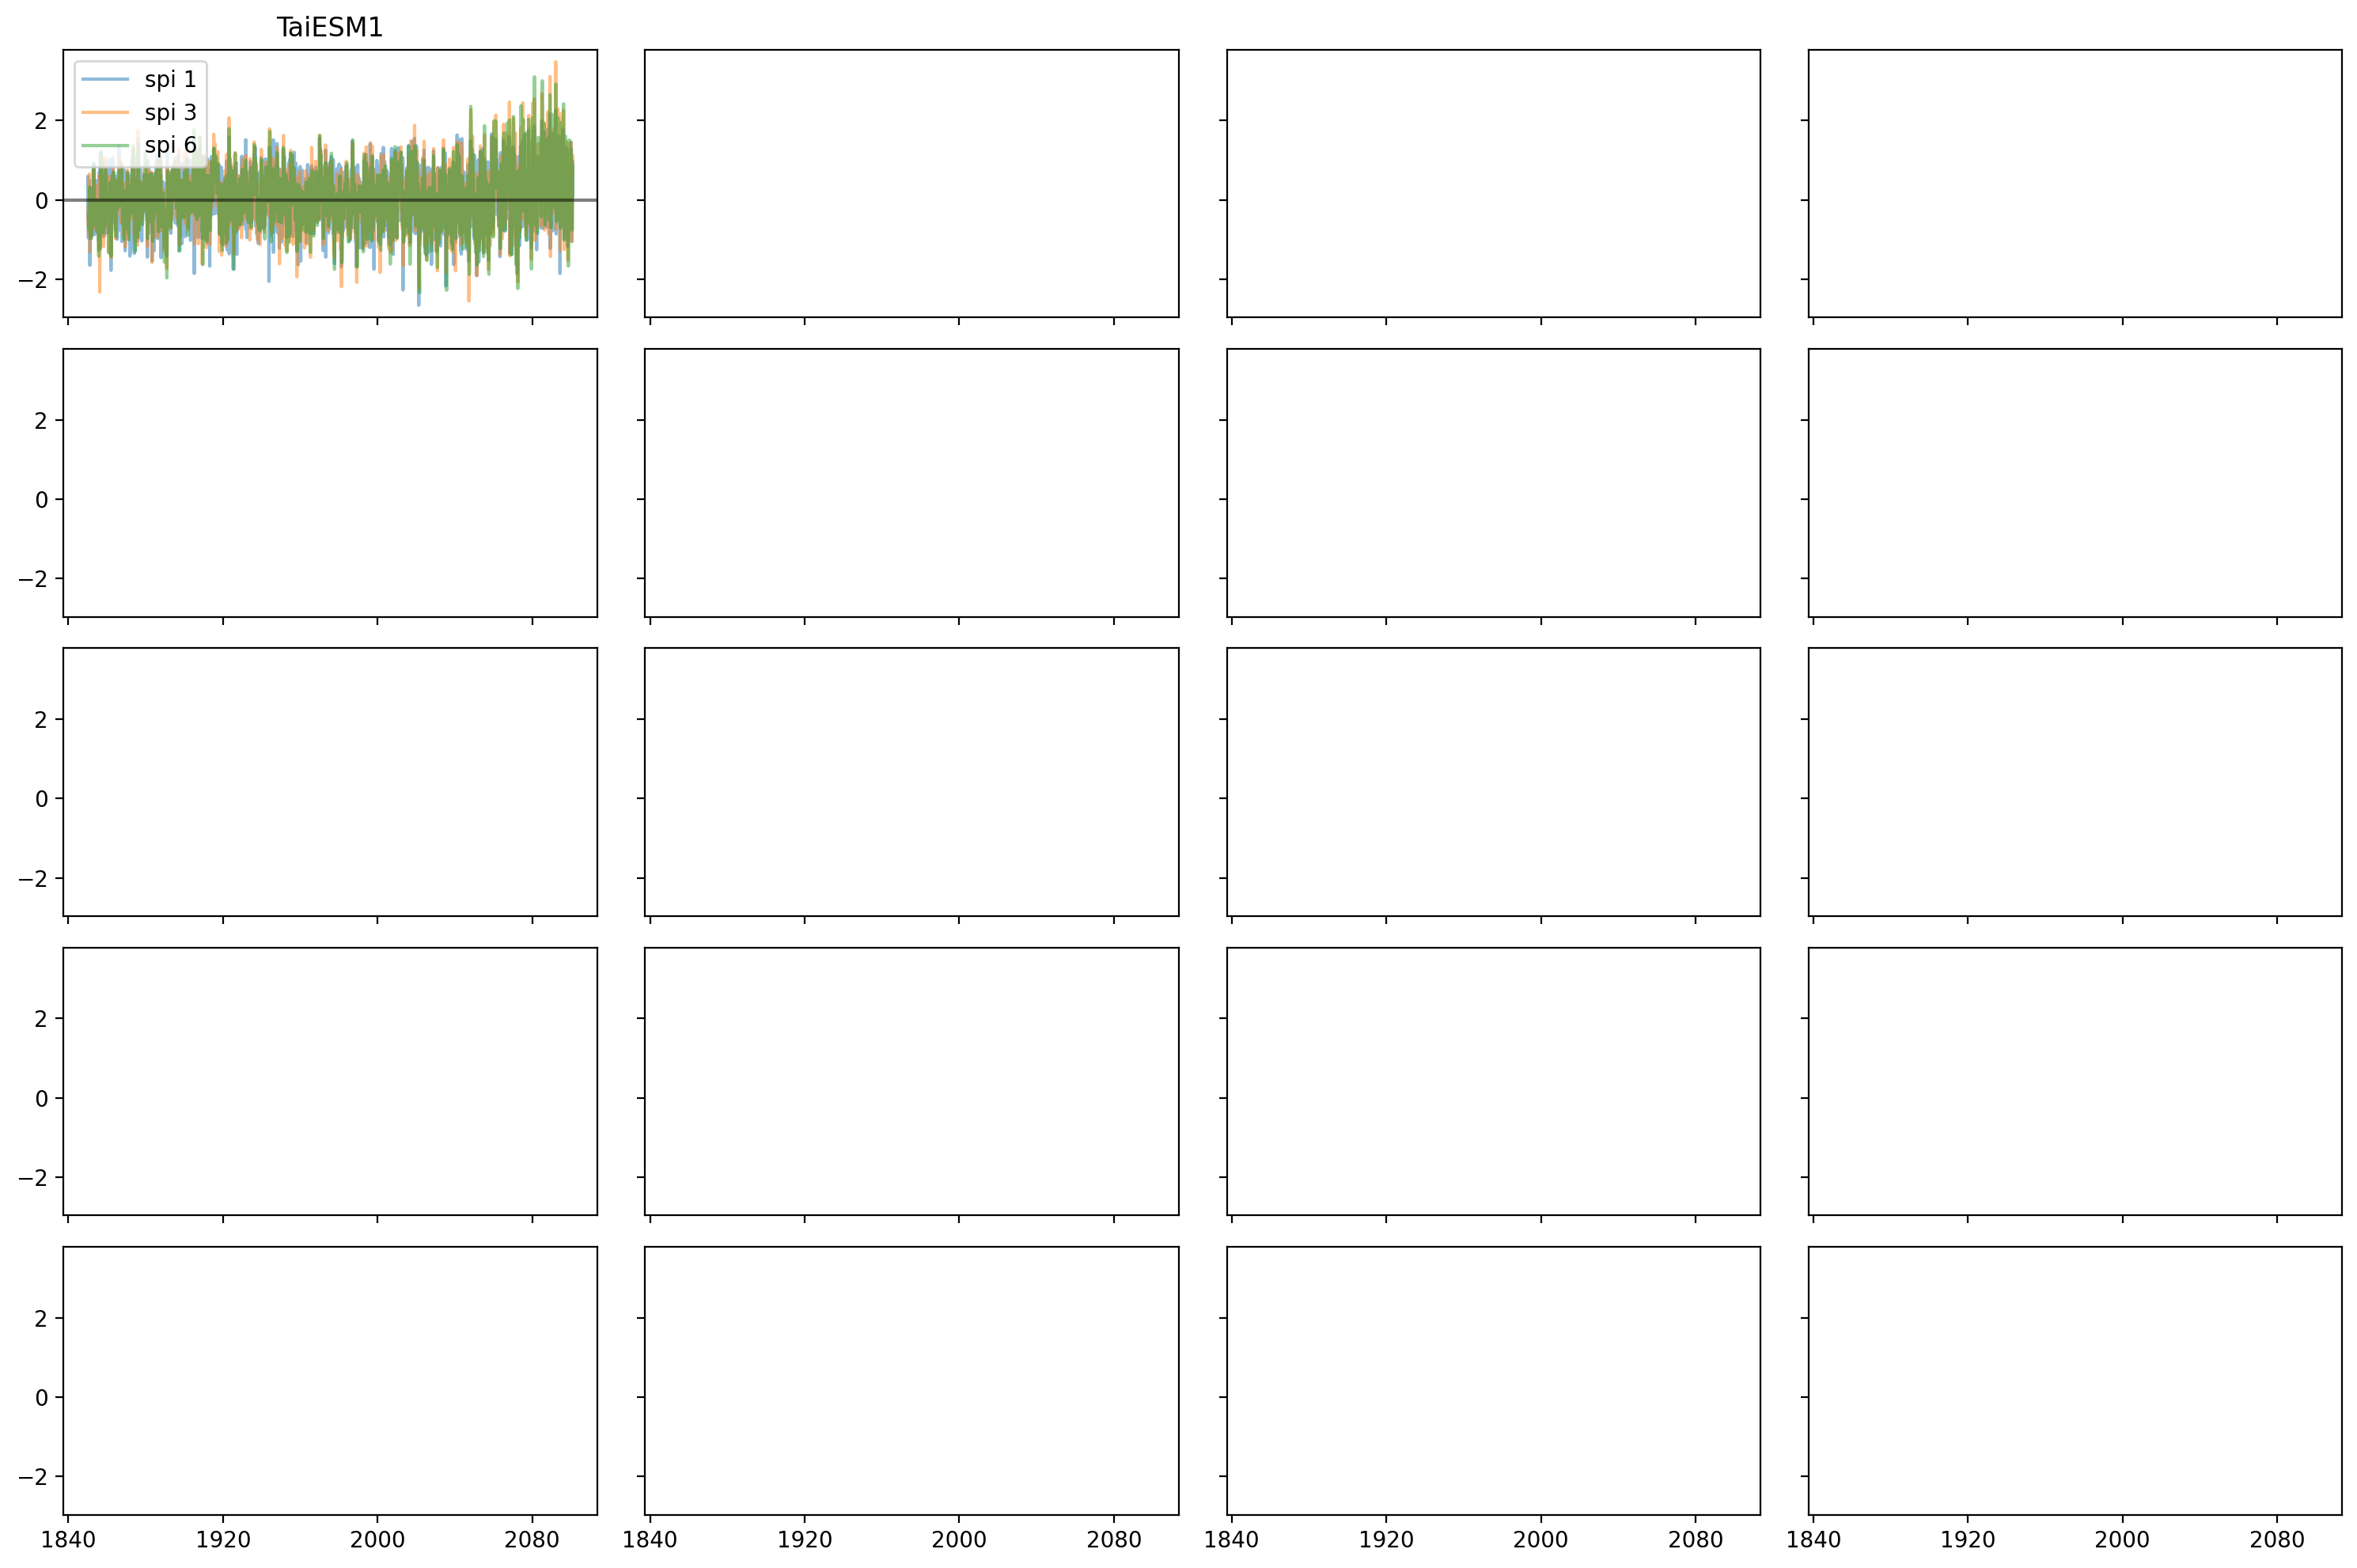

In [18]:
for r in regions:
    region = r[0]

    nrows = 5
    ncols = 4

    fig, axarr = plt.subplots(nrows = nrows, ncols = ncols, figsize = [15, 10], sharex = True, sharey = True)

    for ax, model in zip(axarr.flat, models):
        # global_mean(dicts_spi[region][model]).spi_1.mean(dim = 'member_id').plot(ax = ax, alpha = 0.5, label = 'spi 1')
        # global_mean(dicts_spi[region][model]).spi_3.mean(dim = 'member_id').plot(ax = ax, alpha = 0.5, label = 'spi 3')
        # global_mean(dicts_spi[region][model]).spi_6.mean(dim = 'member_id').plot(ax = ax, alpha = 0.5, label = 'spi 6')
        
        global_mean(dicts_spi[region][model]).spi_1.isel(member_id = 0).plot(ax = ax, alpha = 0.5, label = 'spi 1')
        global_mean(dicts_spi[region][model]).spi_3.isel(member_id = 0).plot(ax = ax, alpha = 0.5, label = 'spi 3')
        global_mean(dicts_spi[region][model]).spi_6.isel(member_id = 0).plot(ax = ax, alpha = 0.5, label = 'spi 6')

        ax.set_title(model)
        ax.axhline(y = 0, alpha = 0.5, color = 'k')
        ax.set_xlabel(None)
        ax.set_ylabel(None)

    axarr[0,0].legend()
    plt.tight_layout()
    plt.show()

### Calculate zscore

Issues: 
- MRI-ESM2-0 still has ridiculous (in `mrsos` and `mrsol` interpolated 30cm) in the future period in Western North America (MED looks fine)
- lots of big spiking anomalies in precip...
- TaiESM1 and NorESM2-MM have single large negative spikes in `mrsos` 
- using 20 year baseline creates strange results

Possible solutions:
- create a mask to limit how big the anomalies can be (this is what I've been doing previously), if that is reasonable, what is the ceiling?
- for TaiESM1 and NorESM2-MM figure out if those large spikes are just single months and remove (fixes just those two models), the no bigger than 5 check currently takes care of these though


Solution:
- remove anomalies that are less than -20 or greater than +20

In [19]:
def standardized_anomaly(ds):
    '''
    Calculate monthlly zscore or standardized anomaly for an 
    entire xarray dataset. This operation will be performed 
    on all data variables in the dataset.
    
    Returns dataset of same shape but with all variables processed.
    
    'wild pixels' e.g. data that approaches infinity due to the likelihood
    of divide by 0 errors is removed. This is set as values greater than or less 
    than 20 on either side of the mean. 
    '''
    
    ### Choose your baseline, we used the 20-year baseline to align with length of 
    ### Global warming level threshold crossing times as used in the  
    ### IPCC's Working Group 1 Sixth Assessment Reprort

    ## 50-year baseline
    #baseline = ds.sel(time = slice('1850', '1900'))
    ## 20-year baseline
    baseline = ds.sel(time = slice('1861', '1880'))
    
    climatology_mean = baseline.groupby("time.month").mean(dim = "time")
    climatology_std = baseline.groupby("time.month").std(dim = "time")

    stand_anomaly = xr.apply_ufunc(
            lambda x, m, s: (x - m) / s,
            ds.groupby("time.month"),
            climatology_mean,
            climatology_std, keep_attrs = True
        )
    
    ## remove wild pixels
    ## this removes any pixels that have an anomaly of less than -20
    ## fills pixels that don't meet criteria with NaNs
    clean_anomaly = stand_anomaly.where(stand_anomaly >= -20)
    
    ## also remove pixels that have an anomaly greater then +20
    clean_anomaly =  clean_anomaly.where(stand_anomaly <= 20)

    
    return clean_anomaly

In [20]:
dicts_anoms = dict()

for region in tqdm(dicts_spi):
    dicts_anoms[region] = dict()
    
    for model in models:
        ds = dicts_spi[region][model]
        
        ds = ds.copy()
        
        ## removing values where the entire area is 0 in the raw data
        ## this is imporobably and there just seem to be extra days thrown in
        ## this will replace those 0s with nans, effectively ignoring them
        ds = ds.where(ds.mrsol.sel(depth = '200cm') != 0)
        
        ds['mrsos_anom'] = standardized_anomaly(ds.mrsos)
        ds['mrsol_anom'] = standardized_anomaly(ds.mrsol)
        
        dicts_anoms[region][model] = ds

  0%|          | 0/2 [00:00<?, ?it/s]

### Get Global Mean Time Series

In [21]:
model_anoms = dict()

for region in tqdm(dicts_anoms):
    model_anoms[region] = dict()
    
    for model in models:
        model_anoms[region][model] = global_mean(dicts_anoms[region][model])

  0%|          | 0/2 [00:00<?, ?it/s]

### Check standardized anomalies

In [22]:
def check_model_anoms(model_anoms, var, region):

    nrows = 5
    ncols = 4

    fig, axarr = plt.subplots(nrows = nrows, ncols = ncols, figsize = [15, 10], sharex = True)

    for ax, model in zip(axarr.flat, models):
        #print(model)
        
        ds = model_anoms[model]
        
        if 'mrsol' in var:
            ds.isel(member_id = 0)[var].sel(depth = '30cm').plot(ax = ax, alpha = 0.6, label = '30cm')
            ds.isel(member_id = 0)[var].sel(depth = '100cm').plot(ax = ax, alpha = 0.6, label = '100cm')
            ds.isel(member_id = 0)[var].sel(depth = '200cm').plot(ax = ax, alpha = 0.6, label = '200cm')
            
            #ax.legend()
            
        else:
            ds.isel(member_id = 0)[var].plot(ax = ax)


        #global_mean(dict_of_ds[model].mean(dim = 'member_id')[var].sel(depth = '30cm')).plot(ax = ax)

        ax.set_title(model)
        ax.set_xlabel(None)
        
        # Subplot lettering
        # from kevin s
        ax.text(0.01,0.98,string.ascii_letters[models.index(model)]+'.',
            transform=ax.transAxes,ha='left',va='top',
            fontsize=15,fontweight='bold',
            bbox={'boxstyle':'round','facecolor':'white','alpha':0.8,'edgecolor':'None','pad':0.1})
        
        ax.axhline(y = 0, linestyle = '--', alpha = 0.5, color = 'k')
        ax.axvline(x = 2015, alpha = 0.5, color = 'k')

    plt.suptitle(str(region) + " | " + str(var), weight = 'bold', fontsize = 16)
    plt.tight_layout()

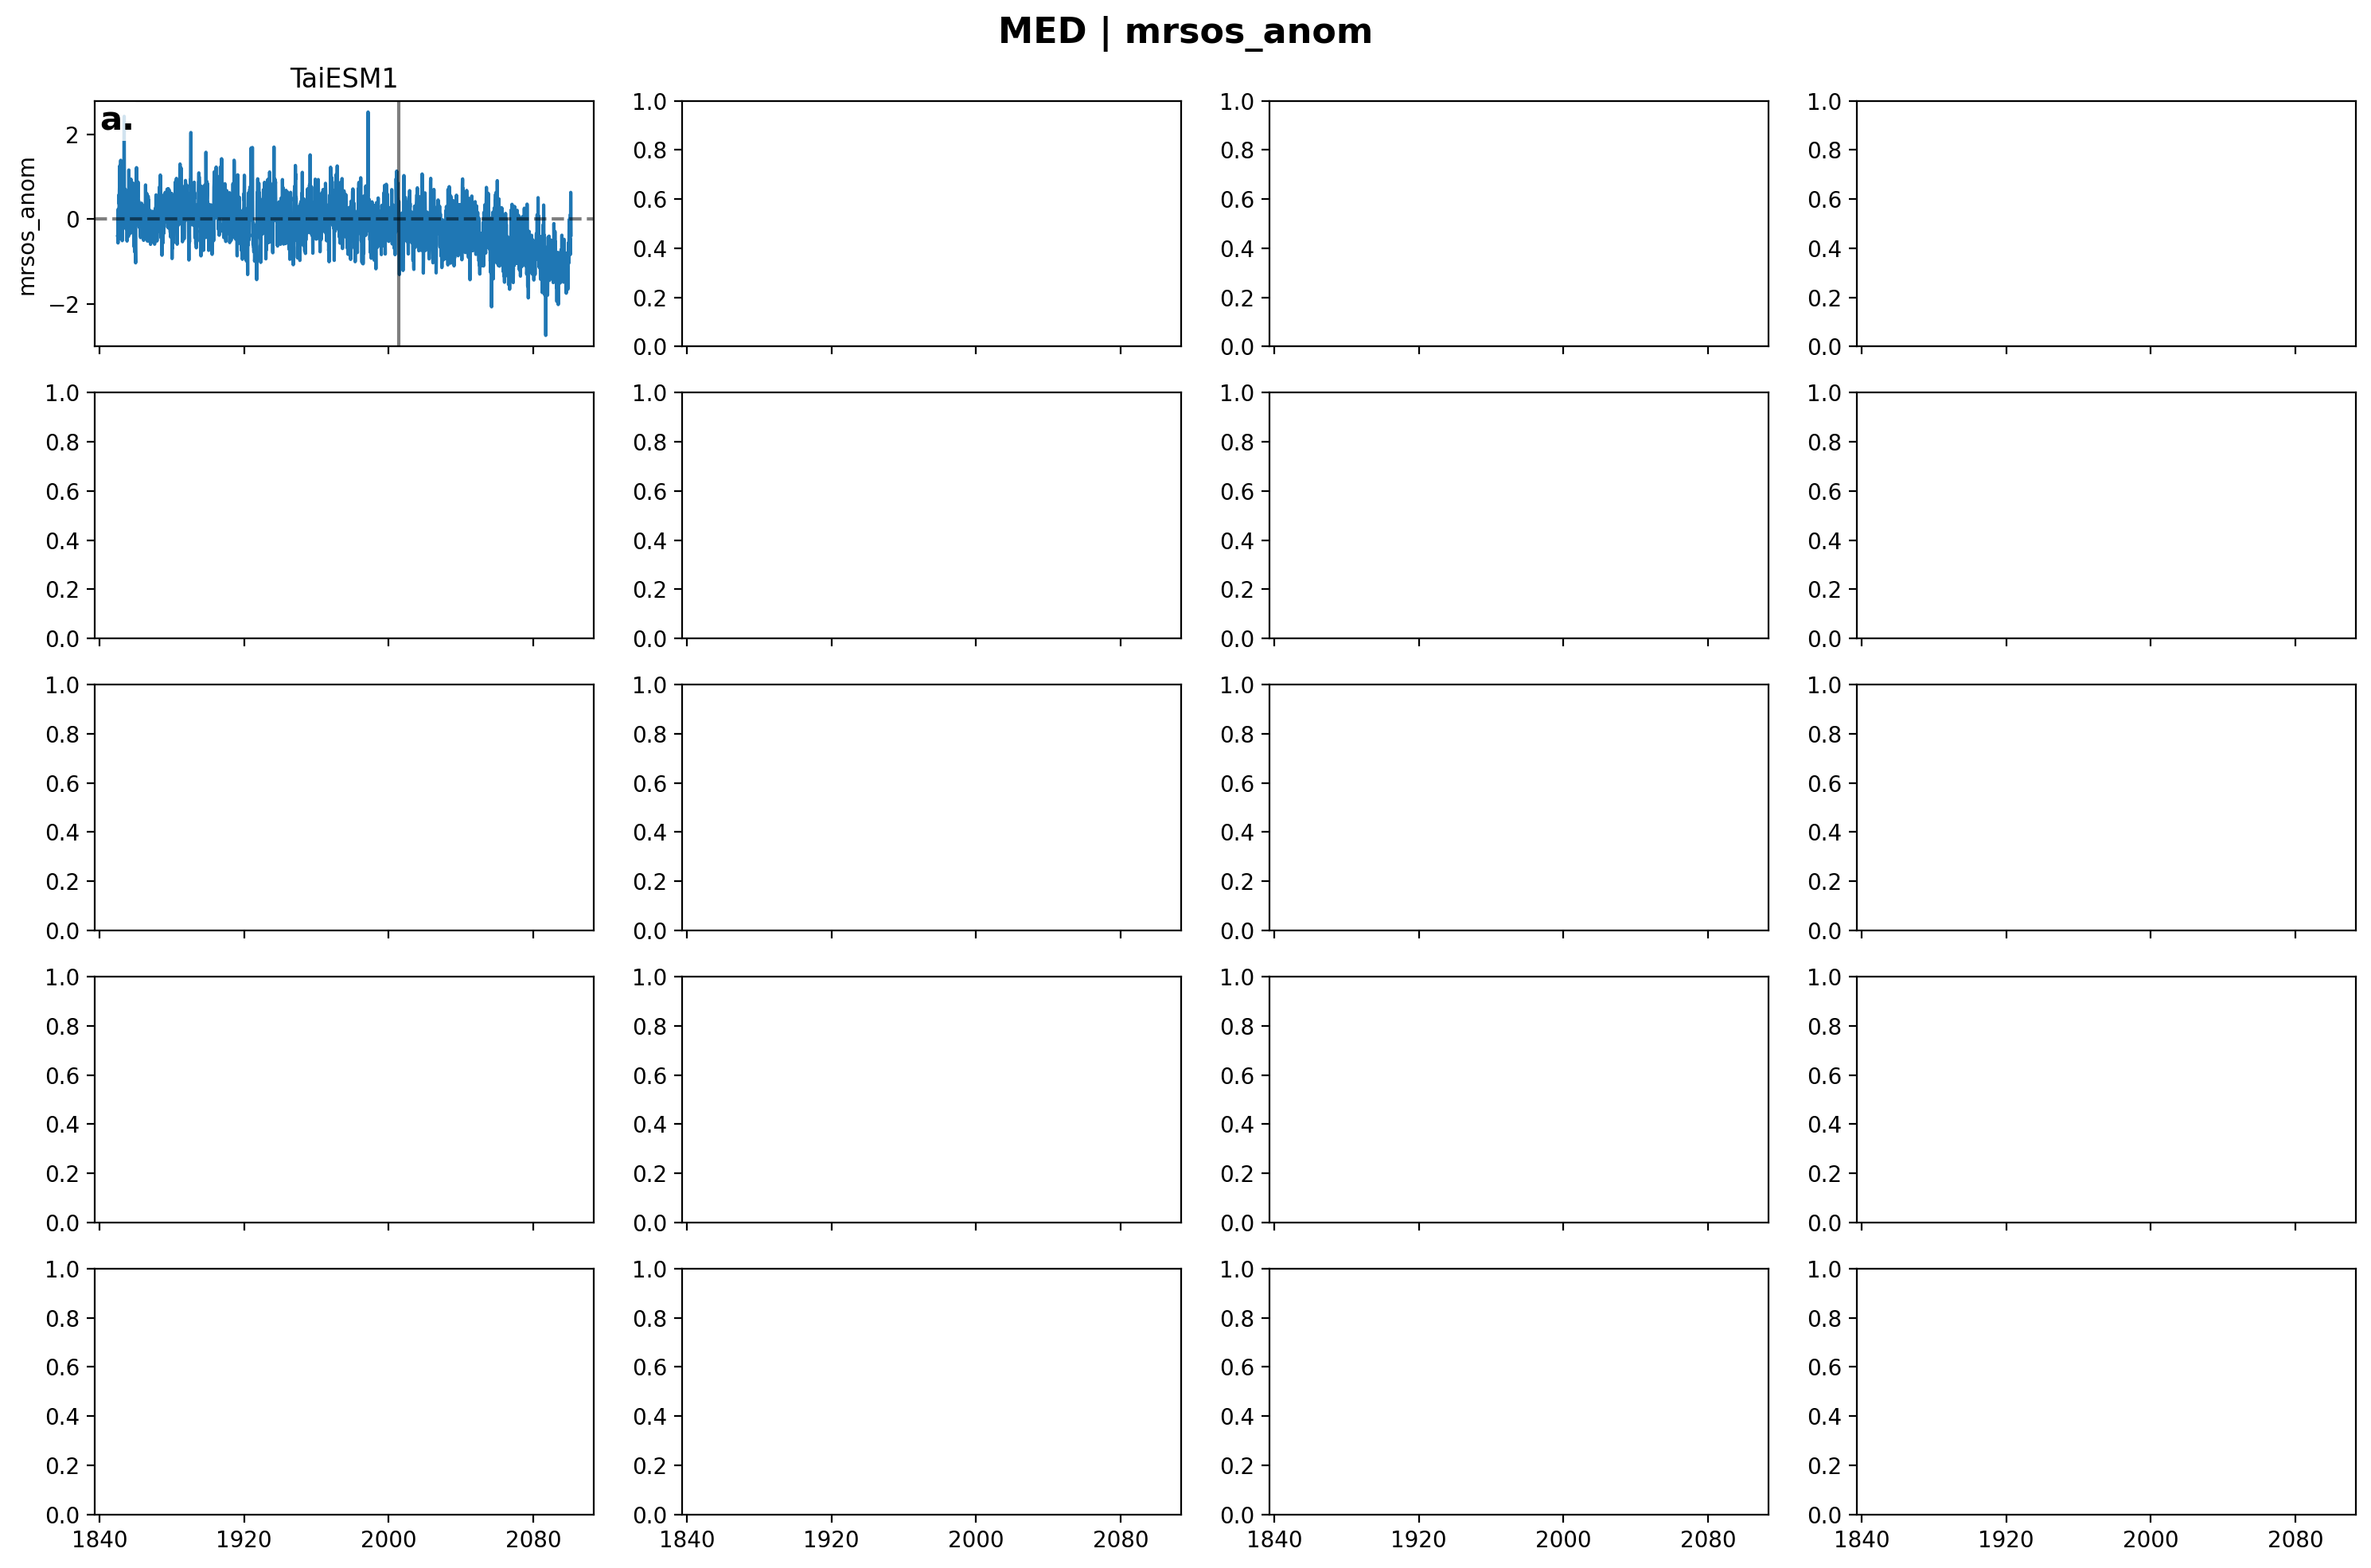

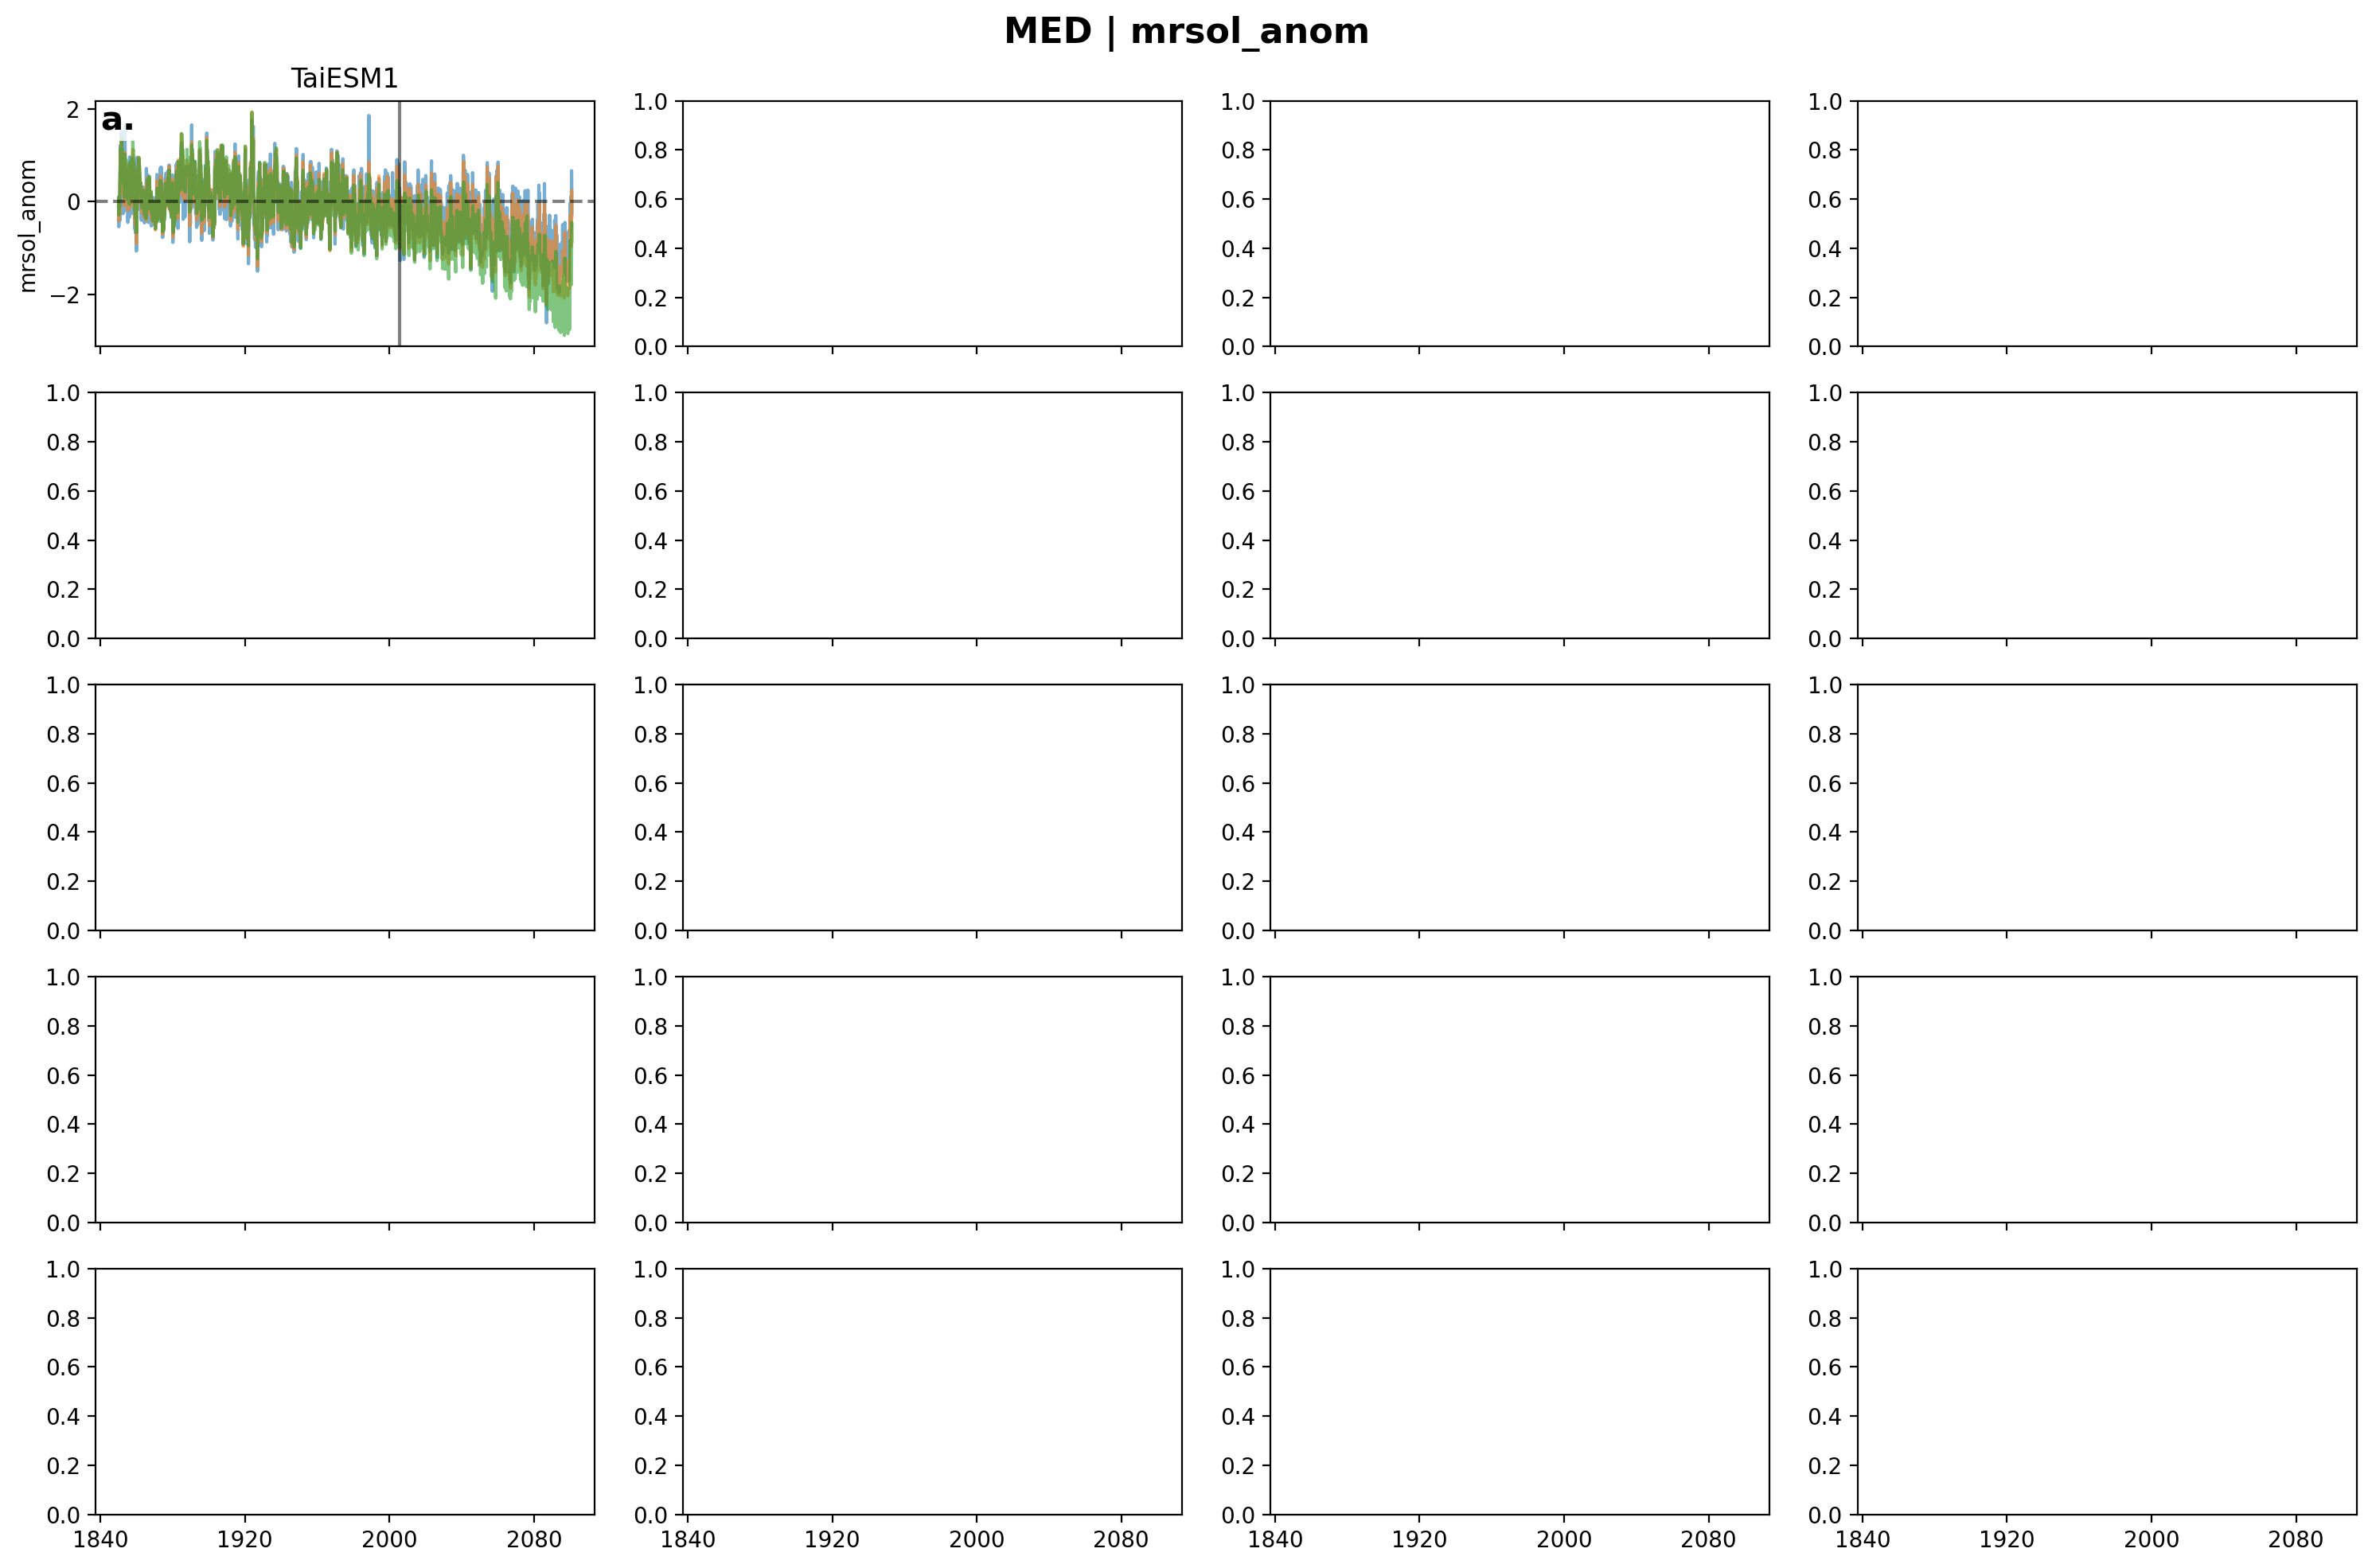

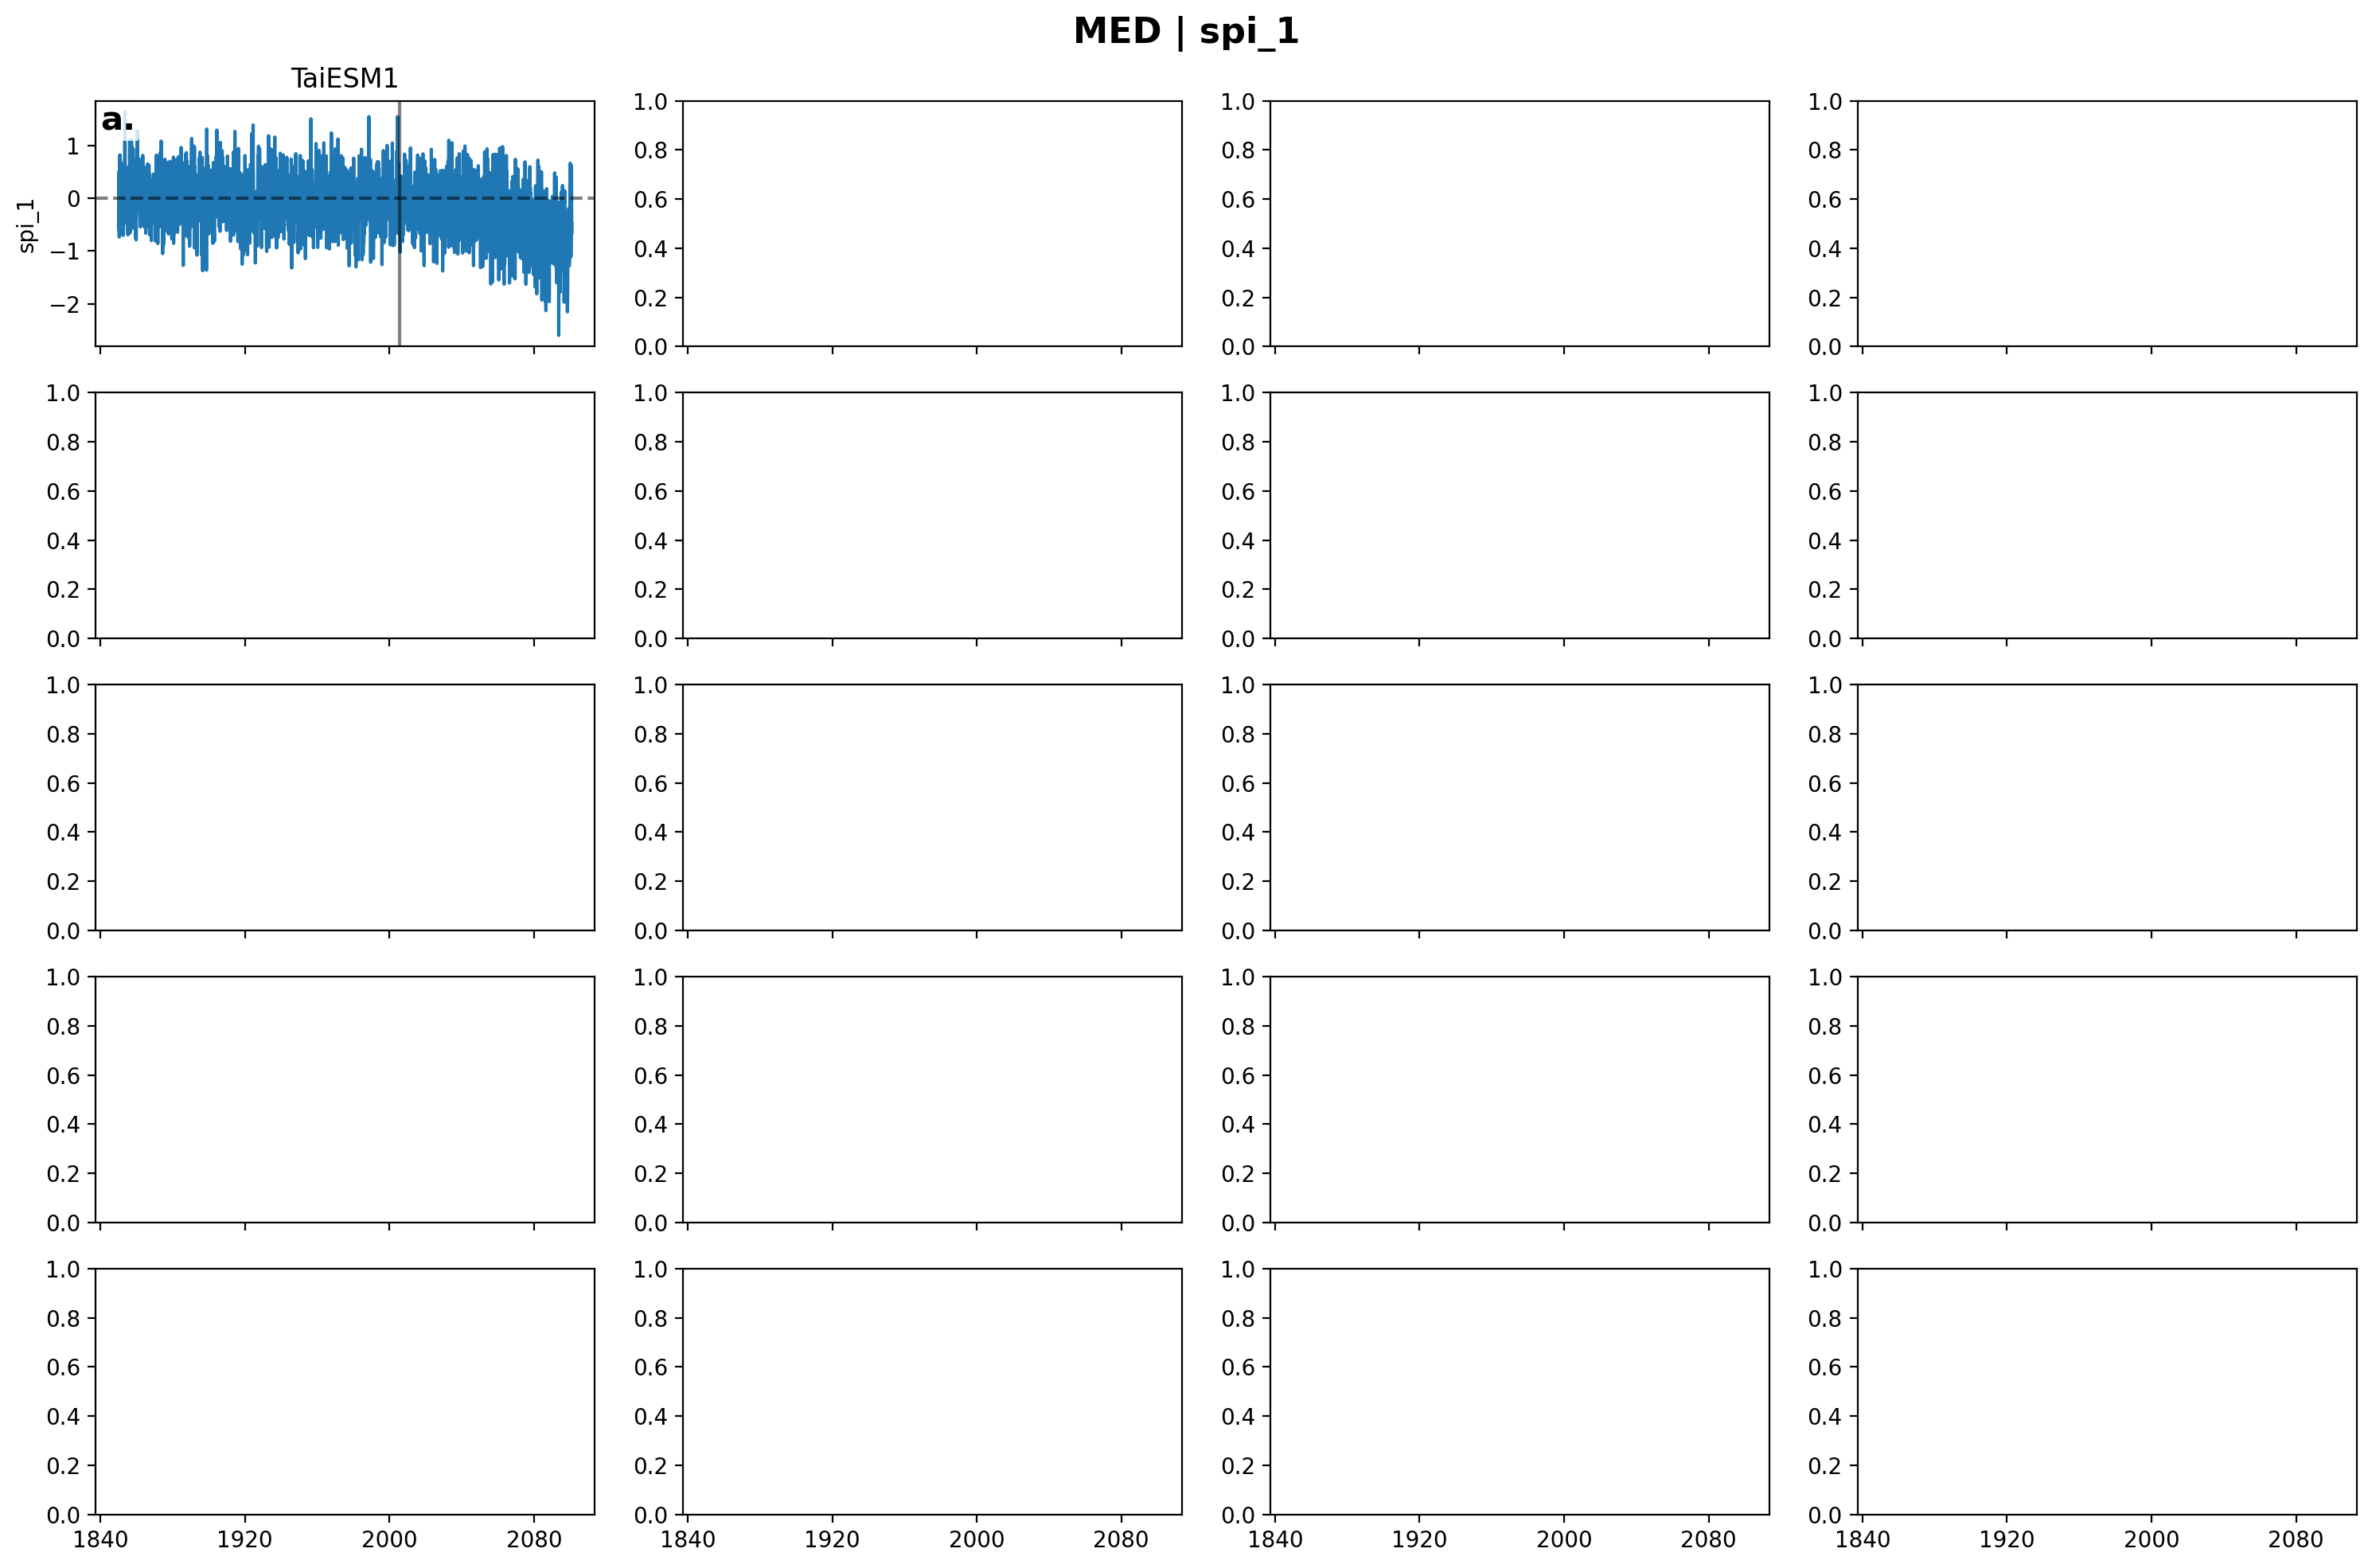

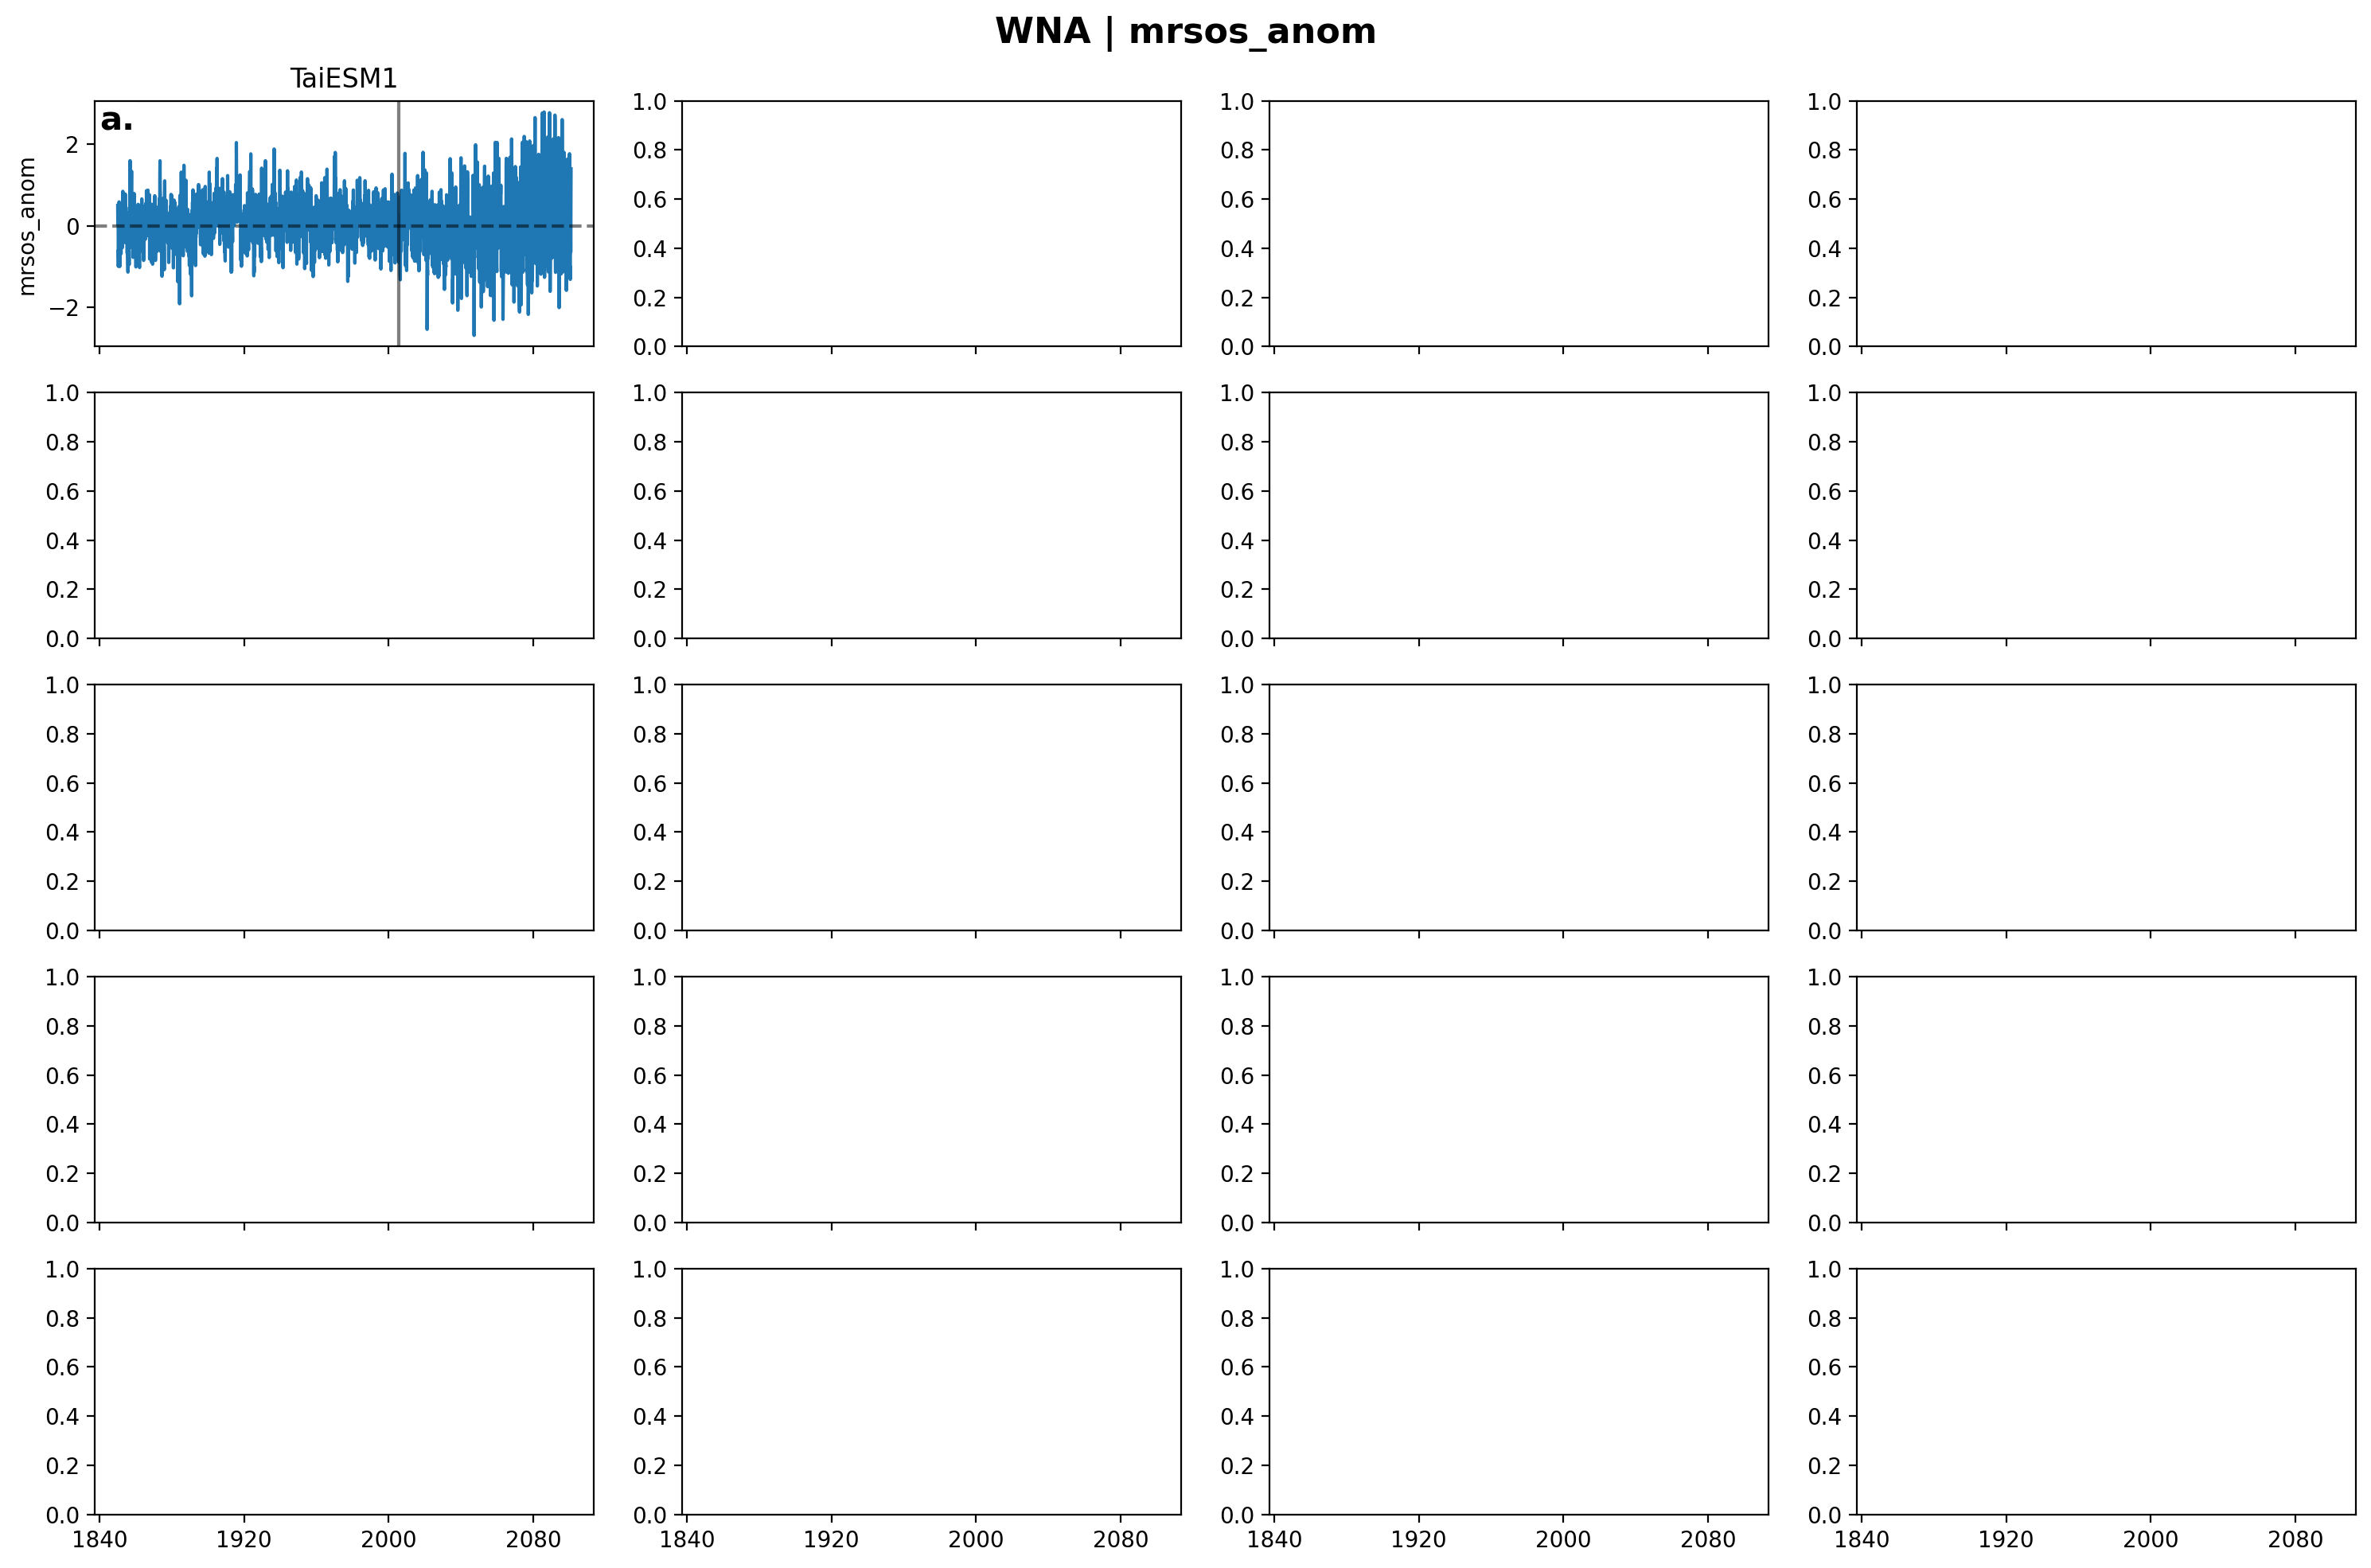

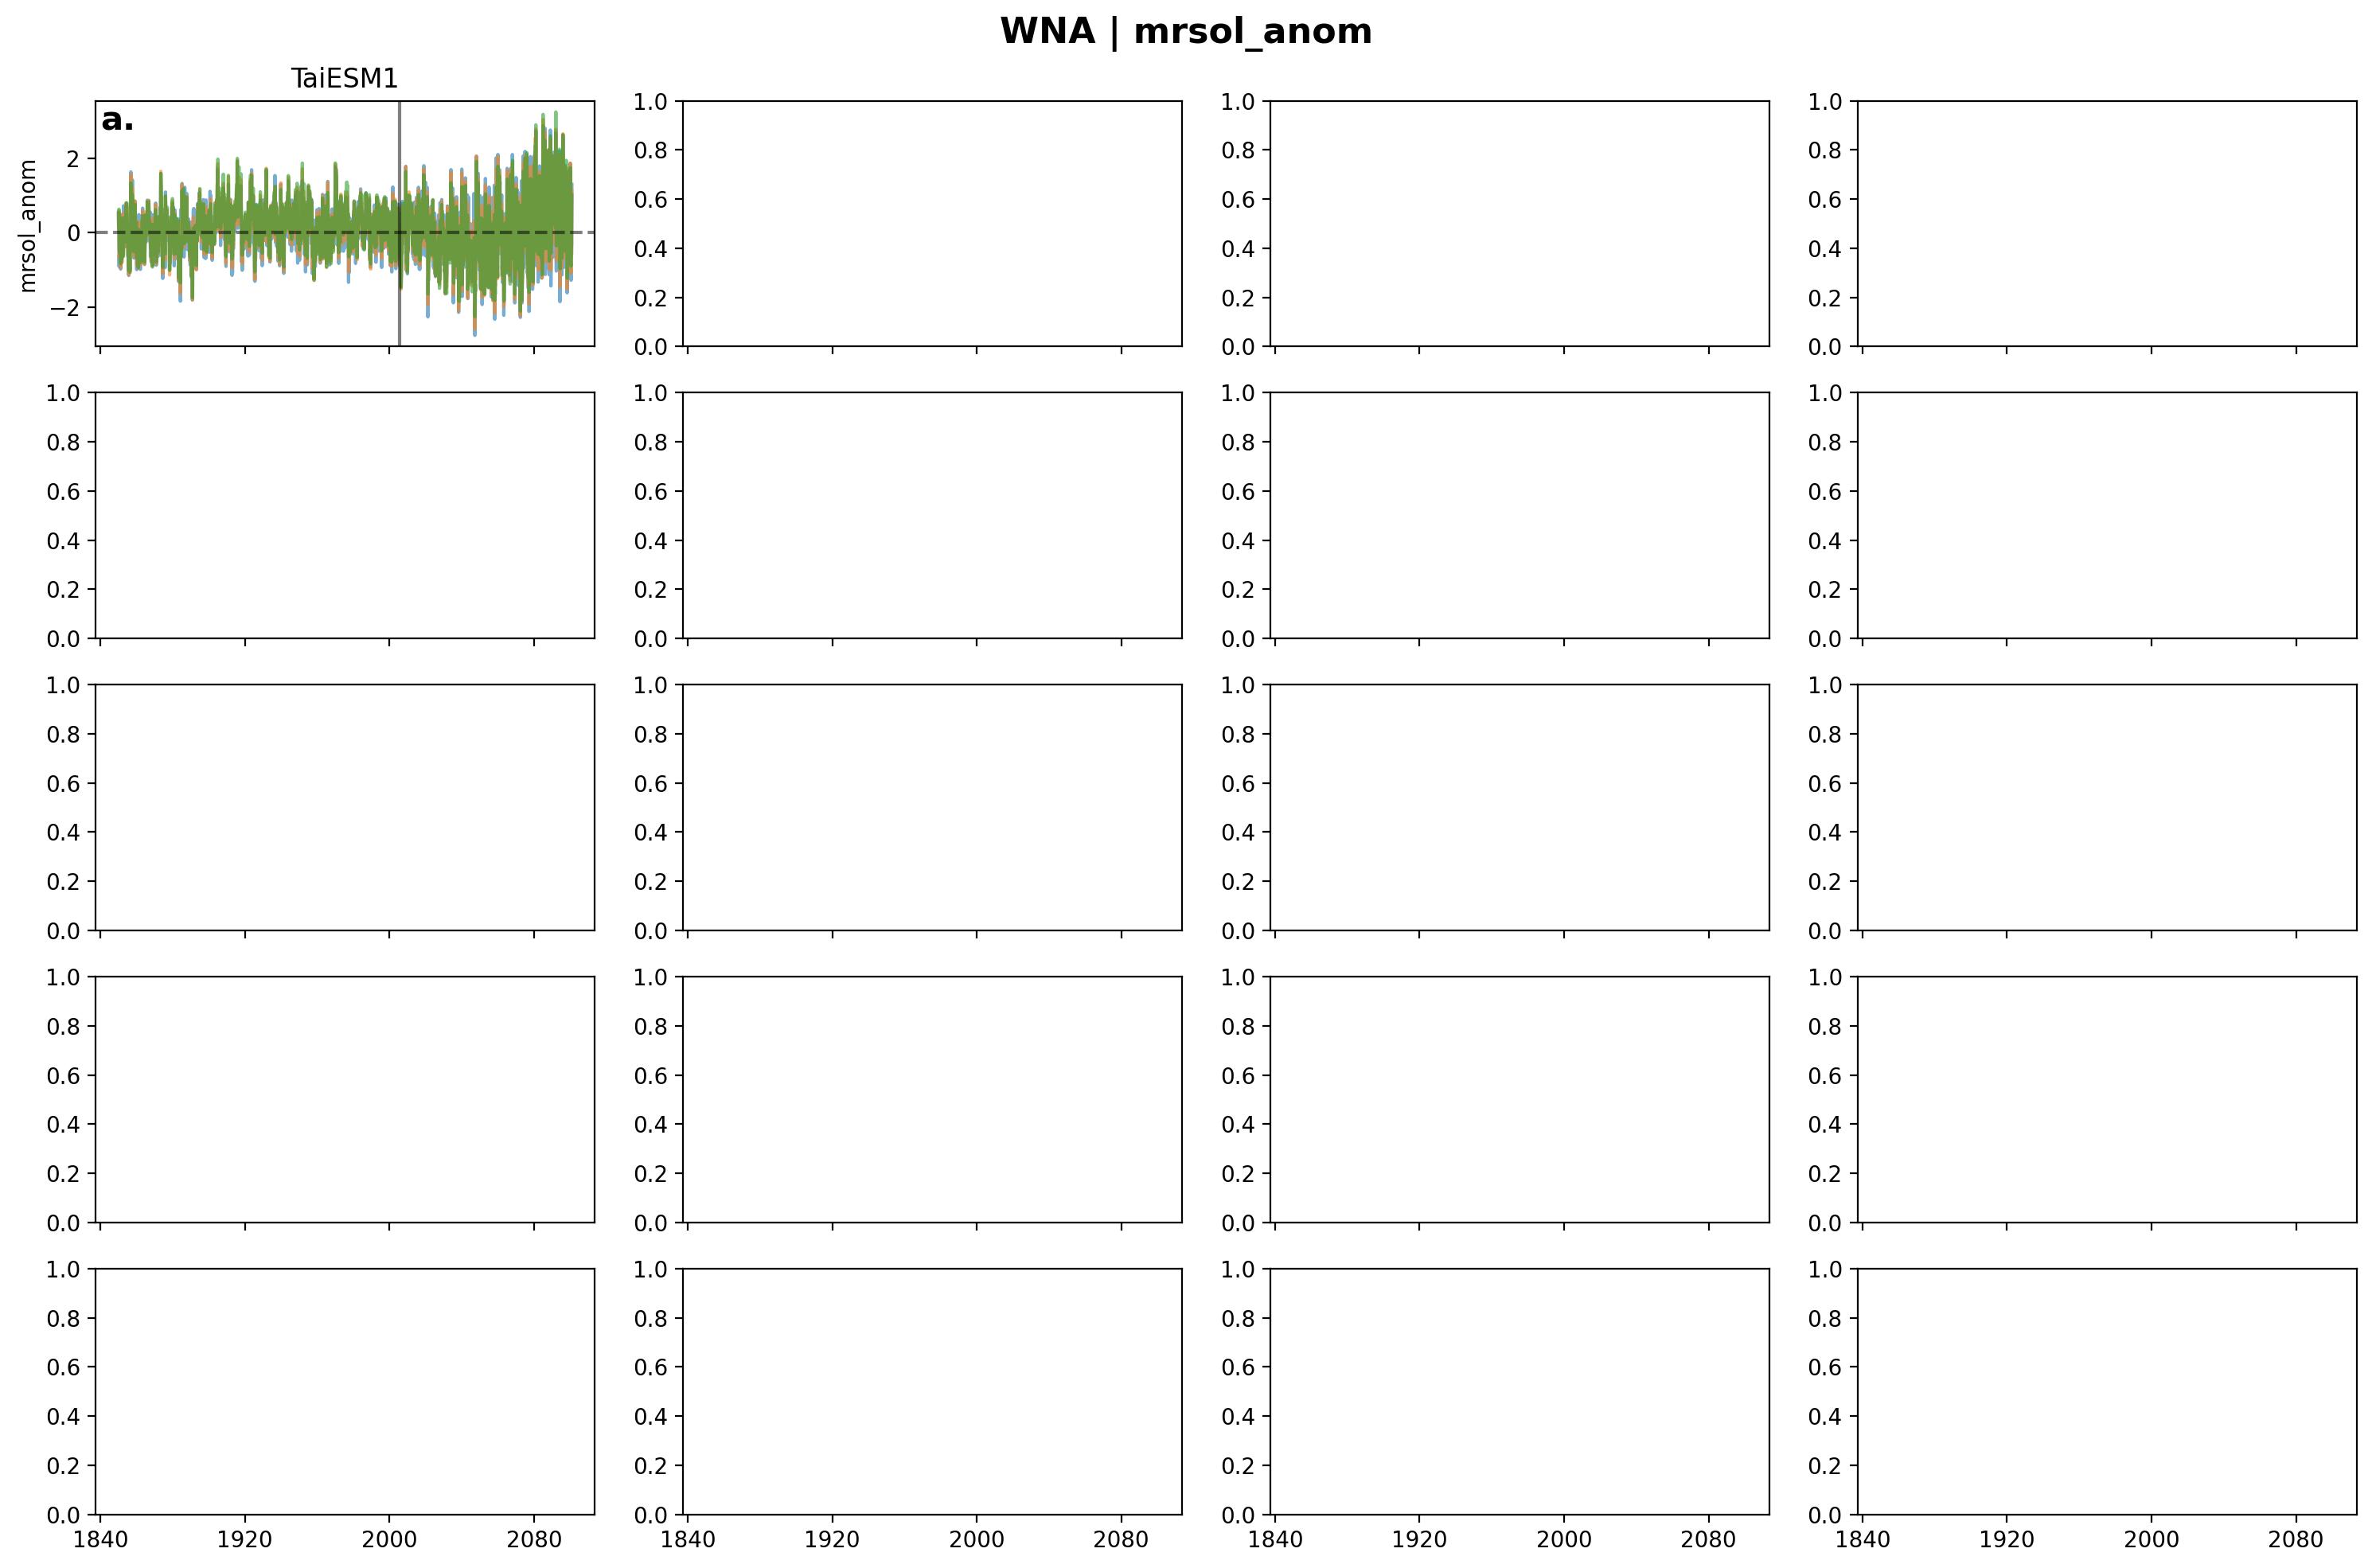

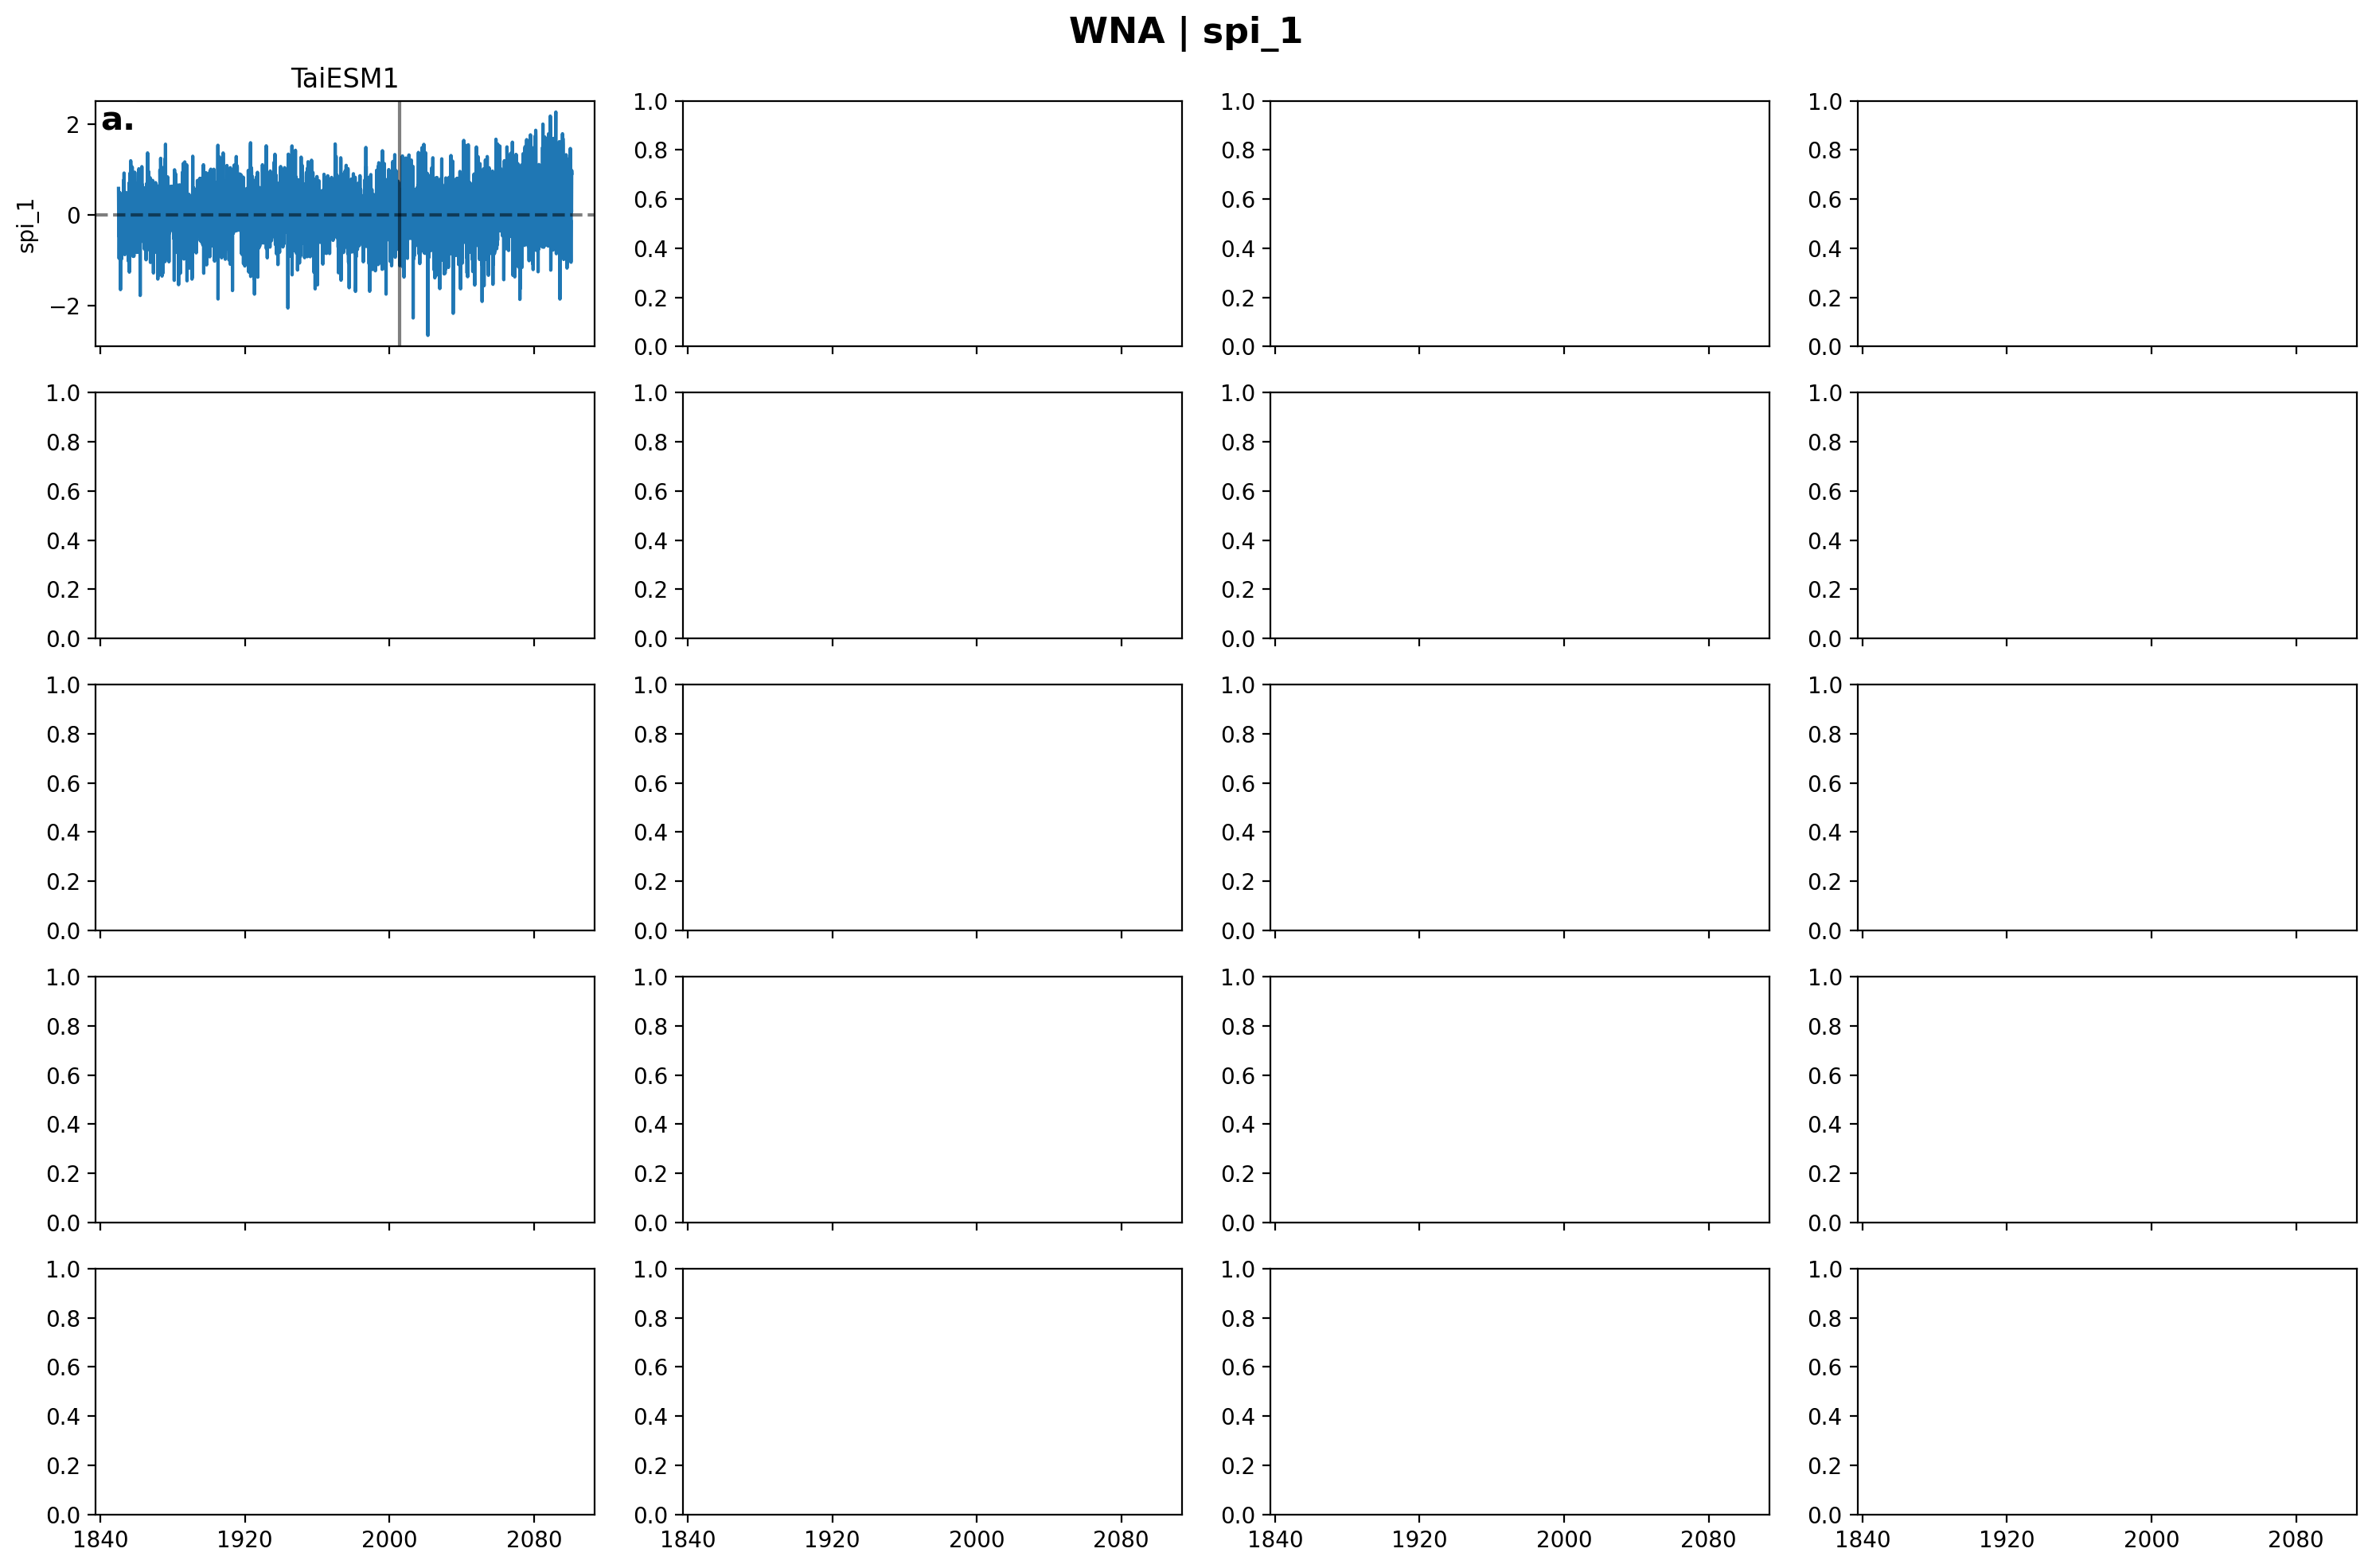

In [23]:
plotting_variables = ['mrsos_anom', 'mrsol_anom', 'spi_1']

for region in model_anoms.keys():
    for var in plotting_variables:
        check_model_anoms(model_anoms[region], var, region)
    #check_model_anoms(model_anoms[region], 'mrsos', region)

#### Check multimodel means:

In [24]:
ensemble_mean_anoms = dict()

for region in regions:
    region = region[0]
    ensemble_mean_anoms[region] = dict()
    for model in tqdm(model_anoms[region].keys()):
    
        ## convert all models to datetimeindex
        datetimeindex = model_anoms[region][model].indexes['time'].to_datetimeindex()
        
        ## take ensemble mean and average over region
        ensemble_mean_anoms[region][model] = model_anoms[region][model].mean(dim = 'member_id')
        ensemble_mean_anoms[region][model]['time'] = datetimeindex

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
multi_model_ensemble = dict()

## calculate multi model average (resample by monthly mean to get all the random dates of the month to combine)
multi_model_ensemble['MED'] = xr.concat([ensemble_mean_anoms['MED'][model] for model in ensemble_mean_anoms['MED'].keys()], dim = 'model', coords = 'minimal', compat = 'override').resample(time="1MS").mean(dim="time")
multi_model_ensemble['WNA'] = xr.concat([ensemble_mean_anoms['WNA'][model] for model in ensemble_mean_anoms['WNA'].keys()], dim = 'model', coords = 'minimal', compat = 'override').resample(time="1MS").mean(dim="time")

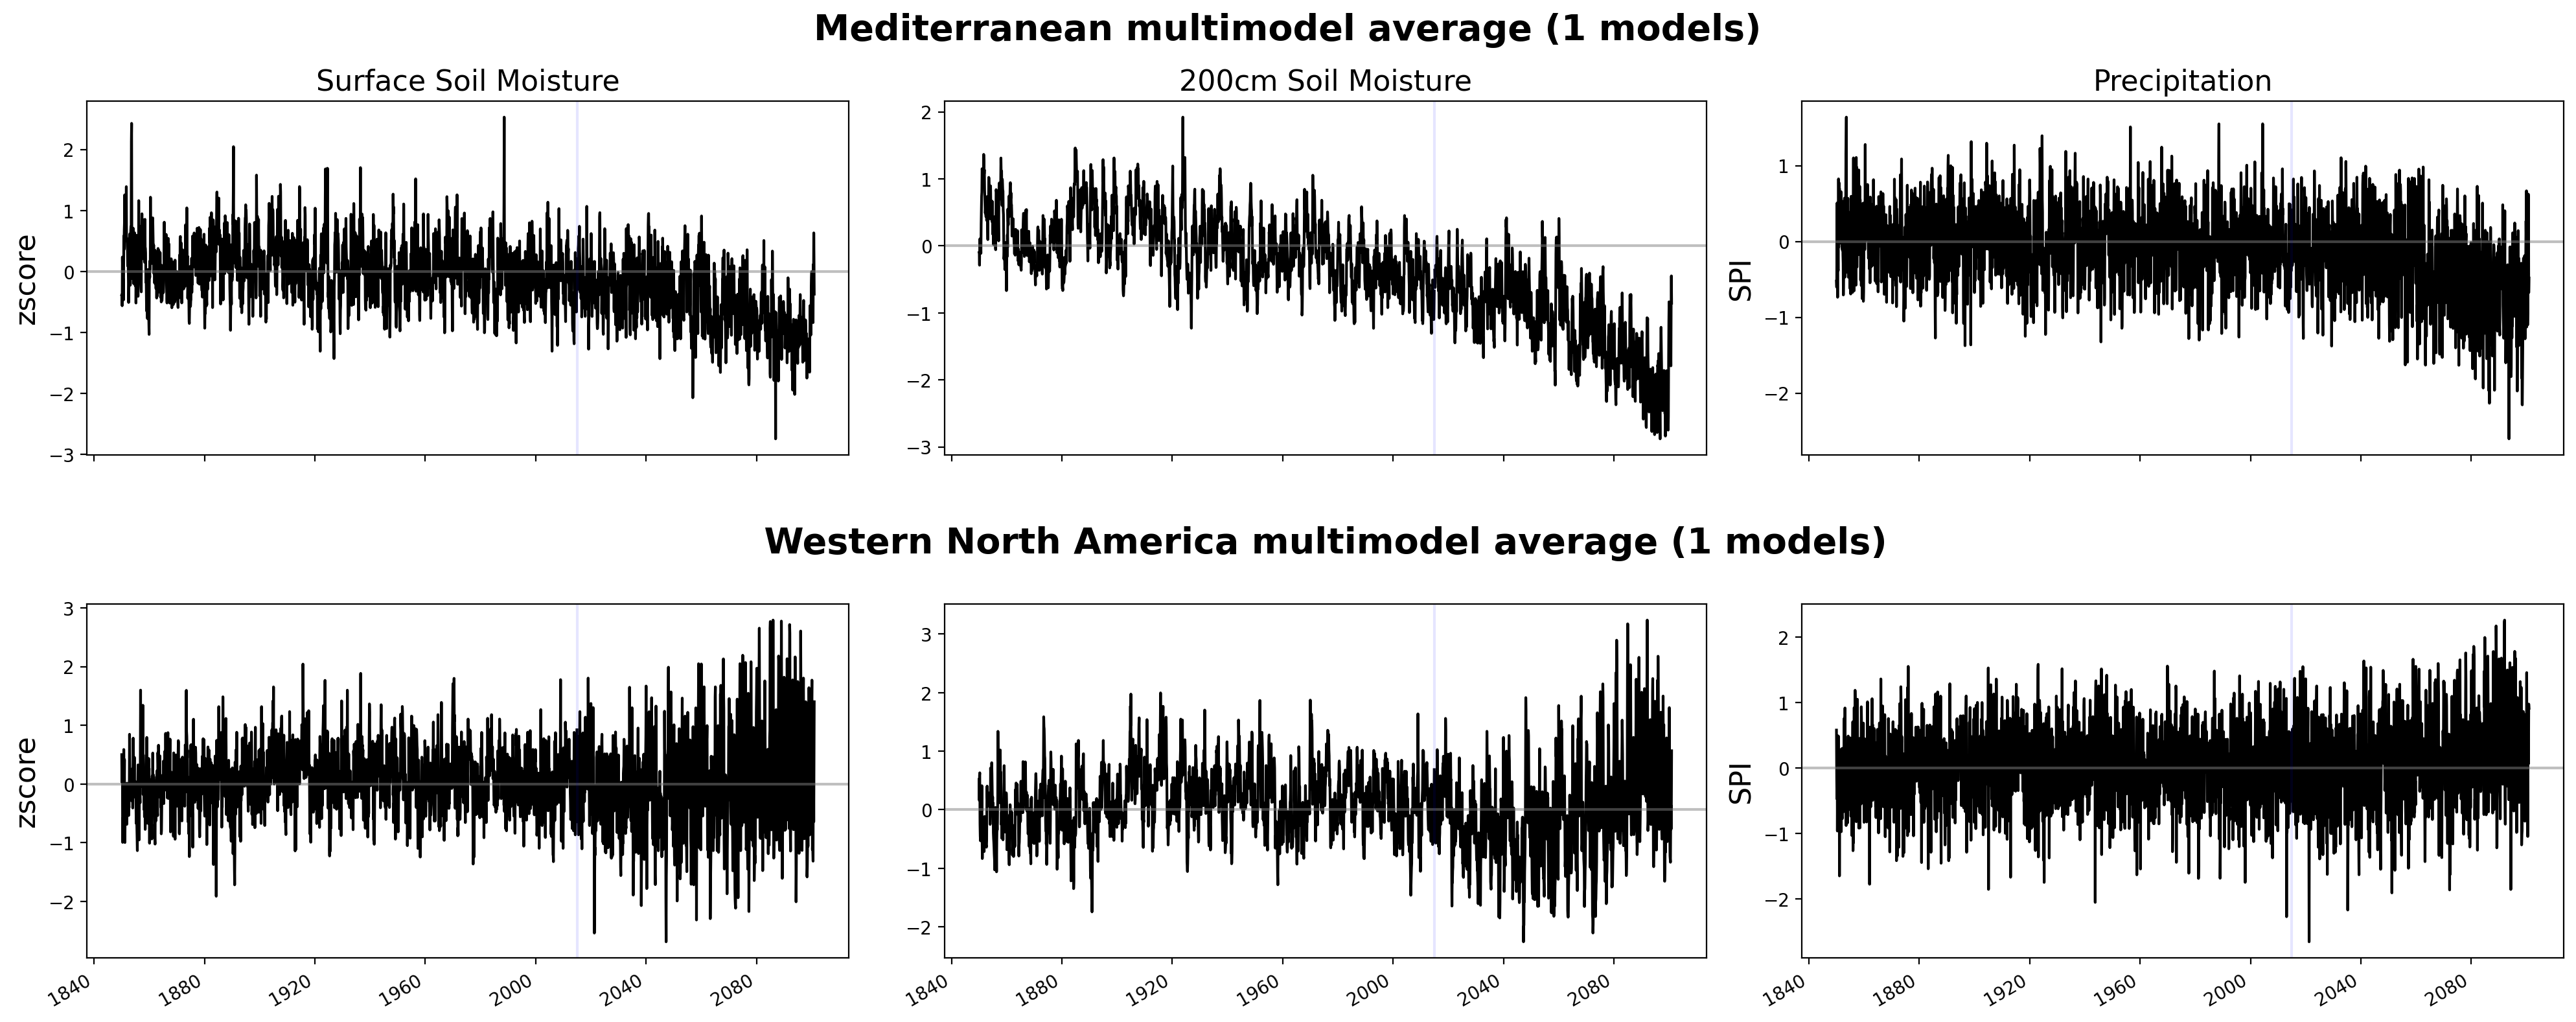

In [26]:
fig, ax = plt.subplots(ncols = 3, nrows = 2, figsize = [20, 8], sharex = True)

multi_model_ensemble['MED'].mrsos_anom.mean(dim = 'model').plot(ax = ax[0,0], color = 'k')
multi_model_ensemble['MED'].mrsol_anom.sel(depth = '200cm').mean(dim = 'model').plot(ax = ax[0,1], color = 'k')
multi_model_ensemble['MED'].spi_1.mean(dim = 'model').plot(ax = ax[0,2], color = 'k')


multi_model_ensemble['WNA'].mrsos_anom.mean(dim = 'model').plot(ax = ax[1,0], color = 'k')
multi_model_ensemble['WNA'].mrsol_anom.sel(depth = '200cm').mean(dim = 'model').plot(ax = ax[1,1], color = 'k')
multi_model_ensemble['WNA'].spi_1.mean(dim = 'model').plot(ax = ax[1,2], color = 'k')

for axes in ax.flat:
    axes.axhline(y = 0, alpha = 0.5, color = 'grey')
    axes.axvline(x = np.datetime64('2015'), alpha = 0.1, color = 'blue')
    axes.set_ylabel(None)
    axes.set_xlabel(None)
    axes.set_title(None)
    
ax[0,0].set_title('Surface Soil Moisture', fontsize = 16)
ax[0,1].set_title('200cm Soil Moisture', fontsize = 16)
ax[0,2].set_title('Precipitation', fontsize = 16)
    
ax[0, 0].set_ylabel('zscore', fontsize = 16)
ax[1, 0].set_ylabel('zscore', fontsize = 16)

ax[0, 2].set_ylabel('SPI', fontsize = 16)
ax[1, 2].set_ylabel('SPI', fontsize = 16)

plt.suptitle('Mediterranean' + ' multimodel average (' + str(len(models)) + ' models)', fontsize = 20, weight = 'bold')
ax[1,1].set_title('\n Western North America' + ' multimodel average (' + str(len(models)) + ' models) \n', fontsize = 20, weight = 'bold')


plt.tight_layout()

### Export processed data

In [27]:
print_string = '-'

for region in tqdm(model_anoms):
    for model in models:
        output_fn = 'exported_data/regions/' + region + '/processed/' + model + '_anom_spi_' + print_string.join(variables) + '.nc'
        
        model_anoms[region][model].to_netcdf(output_fn)
        print(output_fn + ' saved!') 
  

  0%|          | 0/2 [00:00<?, ?it/s]

exported_data/regions/MED/processed/TaiESM1_anom_spi_mrsos-mrsol-pr.nc saved!
exported_data/regions/WNA/processed/TaiESM1_anom_spi_mrsos-mrsol-pr.nc saved!
